# ROC on openpifpaf

In [10]:
import sys, os

class OutputInhibitor():
    def __init__(self, name=None):
        self.name = name
    def __enter__(self):
        if self.name:
            print("Launching {}... ".format(self.name), end="")
        self.ps1, self.ps2 = getattr(sys, "ps1", None), getattr(sys, "ps2", None)
        if self.ps1:
            del sys.ps1
        if self.ps2:
            del sys.ps2
        self.stderr = sys.stderr
        self.fp = open(os.devnull, "w")
        sys.stderr = self.fp
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.ps1:
            sys.ps1 = self.ps1
        if self.ps2:
            sys.ps2 = self.ps2
        sys.stderr = self.stderr
        self.fp.close()
        if self.name:
            print("Done.")


In [11]:
from mlworkflow import PickledDataset, TransformedDataset
from dataset_utilities.ds.instants_dataset import ExtractViewData, ViewCropperTransform
with OutputInhibitor():
    from openpifpaf.datasets.deepsport import AddBallSegmentationTargetViewFactory, AddBallPositionFactory

ds = PickledDataset("/data/mistasse/abolfazl/keemotion/pickled/camera_views_with_human_masks_ball_mask.pickle")

shape = (800,600)

ds = TransformedDataset(ds, [
    ViewCropperTransform(def_min=30, def_max=80, output_shape=shape),
    ExtractViewData(AddBallPositionFactory(), AddBallSegmentationTargetViewFactory()),
])

In [12]:
import random
keys = list(PickledDataset("/data/mistasse/abolfazl/keemotion/pickled/camera_views_with_human_masks_ball_mask.pickle").keys.all())
random.seed(0)
random.shuffle(keys)
validation_set_size_pc = 15
lim = len(keys)*validation_set_size_pc//100
training_keys = keys[lim:]
validation_keys = keys[:lim]
testing_keys = [k for k in ds.yield_keys() if k not in training_keys and k not in validation_keys]
print(len(validation_keys))
print(len(training_keys))

100
572


In [13]:
import tensorflow as tf
import numpy as np
from tf_layers import AvoidLocalEqualities, PeakLocalMax, ComputeElementaryMetrics
class ChunkProcessor:
    pass
class CastFloat(ChunkProcessor):
    def __init__(self, tensor_name):
        self.tensor_name = [tensor_name] if isinstance(tensor_name, str) else tensor_name
    def __call__(self, chunk):
        for tensor_name in self.tensor_name:
            if tensor_name in chunk:
                chunk[tensor_name] = tf.cast(chunk[tensor_name], tf.float32)
class Normalize(ChunkProcessor):
    def __init__(self, tensor_name):
        self.tensor_name = tensor_name
    def __call__(self, chunk):
        assert chunk[self.tensor_name].dtype == tf.float32
        chunk[self.tensor_name] = chunk[self.tensor_name]/255
class ComputeKeypointsDetectionAccuracy(ChunkProcessor):
    def __init__(self, non_max_suppression_pool_size=50, threshold=0.5, target_enlargment_size=10):
        thresholds = threshold if isinstance(threshold, np.ndarray) else np.array([threshold])
        assert len(thresholds.shape) == 1, "'threshold' argument should be 1D-array (a scalar is also accepted)."

        self.avoid_local_eq = AvoidLocalEqualities()
        self.peak_local_max = PeakLocalMax(min_distance=non_max_suppression_pool_size//2, thresholds=thresholds)
        self.enlarge_target = tf.keras.layers.MaxPool2D(target_enlargment_size, strides=1, padding="same")
        self.compute_metric = ComputeElementaryMetrics()

    def __call__(self, chunk):
        batch_target = tf.cast(chunk["batch_target"], tf.float32)
        batch_target = batch_target if len(batch_target.shape) == 4 else batch_target[...,tf.newaxis]
        batch_output = chunk["batch_heatmap"]
        batch_output = batch_output if len(batch_output.shape) == 4 else batch_output[...,tf.newaxis]

        batch_output = self.avoid_local_eq(batch_output)
        batch_hitmap = self.peak_local_max(batch_output)
        batch_hitmap = tf.cast(batch_hitmap, tf.int32)
        chunk["batch_hitmap"] = tf.squeeze(batch_hitmap)
        batch_target = self.enlarge_target(batch_target)
        batch_target = tf.cast(batch_target, tf.int32)[..., tf.newaxis]

        batch_metric = self.compute_metric(batch_hitmap=batch_hitmap, batch_target=batch_target)
        chunk["batch_TP"] = tf.squeeze(batch_metric["batch_TP"])
        chunk["batch_FP"] = tf.squeeze(batch_metric["batch_FP"])
        chunk["batch_TN"] = tf.squeeze(batch_metric["batch_TN"])
        chunk["batch_FN"] = tf.squeeze(batch_metric["batch_FN"])

        
chunk = {}
chunk["batch_heatmap"] = tf.keras.Input(dtype=tf.uint8, shape=(shape[1], shape[0]), name="batch_heatmap")
chunk["batch_target"] = tf.keras.Input(dtype=tf.uint8, shape=(shape[1], shape[0]), name="batch_target")
inputs = dict(chunk) # makes a copy

thresholds = np.array([])
n_points = 21
chunk_processors = [
    CastFloat(["batch_heatmap", "batch_target"]),
    Normalize("batch_heatmap"),
    ComputeKeypointsDetectionAccuracy(non_max_suppression_pool_size=20, threshold=np.linspace(0,1,n_points)),
]
for cp in chunk_processors:
    cp(chunk)

outputs = {k:chunk[k] for k in chunk if k in ["batch_TP", "batch_TN", "batch_FP", "batch_FN"]}
model = tf.keras.Model(inputs, outputs)

In [14]:
from matplotlib import pyplot as plt
def plot(current_result, set_name, fig=None):
    fig = fig or plt.figure()
    x = current_result["FP"]/(current_result["FP"]+current_result["TN"])
    y = current_result["TP"]/(current_result["TP"]+current_result["FN"])
    ax = fig.gca()
    ax.plot(x, y, linestyle="-", linewidth=1, markersize=5, marker=".", label=set_name)
    index=10
    ax.plot(x[index], y[index], markersize=10, marker=".", color="green")
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.axis("equal")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_box_aspect(1)
    ax.set_title(f"ROC ball detection from PIFPAF")
    ax.legend()
    return fig

In [15]:
from IPython import display
from ipywidgets import Output

output = Output()
display.display(output)

Output()

In [16]:
def infer(weight_file, data):
    image_filename = "image/tmp_image.png"
    imageio.imwrite(image_filename, data["input_image"])
    sys.argv = [
        "aue",
        image_filename,
        "--checkpoint", weights_file,
        "--image-output",
        "--debug-images", "--debug-cif-c", "--debug"
    ]
#     with OutputInhibitor():
    if True:
        main()
    return imageio.imread("image/test.accumulated.png")

In [17]:
import os
from tqdm.notebook import tqdm
from openpifpaf.predict import main
import sys
import imageio
import numpy as np
import pickle

#weights_file = "shufflenetv2k16w-210225-164102-ball-edge501.pkl.epoch150" # trained on small dataset
#weights_file = "shufflenetv2k16w-210308-164747-ball-edge501.pkl.epoch150" # trained on full dataset
#weights_file = "shufflenetv2k16-210309-153430-ball-edge501.pkl.epoch200" # trained on small dataset with fixed seed
#weights_file = "shufflenetv2k16-210309-220522-ball.pkl.epoch499" # trained on small dataset with fixed seed
weights_file = '/data/mistasse/abolfazl/outputs/resnet50-210312-010148-cifcent-pan-ball-edge641.pkl.epoch200'
# import glob
#for filename in glob.glob("outputs/resnet*.log"):
#for filename in glob.glob("outputs/*210312-0[89]*.log"):
# for filename in glob.glob("outputs/*210312-1*.log"):
    #weights_file = filename.replace(".log", ".epoch100")
#     weights_file = glob.glob(filename.replace(".log", ".epoch*"))[-1]
    #weights_file = "results/shufflenetv2k16w-210308-164747-ball-edge501.pkl.epoch150"
# if not os.path.isfile(weights_file):
#     #raise
#     continue
filename = weights_file
sets_results = {}
for set_name in ["training_keys", "validation_keys"]: # "testing_keys"
    current_result = sets_results[set_name] = {}
    current_result["TP"] = np.zeros(n_points, np.int32)
    current_result["FP"] = np.zeros(n_points, np.int32)
    current_result["TN"] = np.zeros(n_points, np.int32)
    current_result["FN"] = np.zeros(n_points, np.int32)
    for key in tqdm(eval(set_name)):
        data = ds.query_item(key)
        if data is None:
            continue

        heatmap = infer(weights_file, data)

        result = model({"batch_heatmap": heatmap[np.newaxis], "batch_target": data["mask"][np.newaxis]})
        current_result["TP"] += result["batch_TP"].numpy()
        current_result["FP"] += result["batch_FP"].numpy()
        current_result["TN"] += result["batch_TN"].numpy()
        current_result["FN"] += result["batch_FN"].numpy()
        with output:
            display.clear_output(wait=True)
            fig = plot(current_result, set_name)
            display.display(fig)
sets_results["filename"] = filename
pickle.dump(sets_results, open(filename+".pickle", "wb"))

  0%|          | 0/572 [00:00<?, ?it/s]

DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f42bb310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.018s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.454s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec203490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.488s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec185e50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.586s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [6, 9, 9, 8, 9, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.595s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec0eecd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 28, 0.810s
INFO:openpifpaf.decoder.generator.cifpanball:28 annotations: [1, 10, 3, 1, 3, 1, 4, 11, 2, 3, 4, 3, 1, 5, 1, 3, 6, 7, 4, 1, 1, 2, 3, 1, 4, 4, 1, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.819s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9f54ed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.032s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.529s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [6, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.538s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9eb7310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.661s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [1, 4, 2, 4, 4, 4, 5, 3, 2, 13, 8, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.668s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9d9bc50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.032s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.629s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [1, 2, 1, 6, 1, 11, 1, 7, 1, 1, 4, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.636s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9c41b50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.032s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.602s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [6, 1, 6, 10, 4, 4, 1, 5, 7, 13, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.610s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9babd90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.018s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.707s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [1, 4, 6, 5, 4, 1, 15, 2, 1, 6, 3, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.073s, dec = 0.716s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9abad10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.743s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [4, 4, 13, 8, 10, 1, 2, 14, 3, 3, 9, 1, 1, 4, 11, 2, 1, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.754s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9961dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 30, 0.869s
INFO:openpifpaf.decoder.generator.cifpanball:30 annotations: [2, 3, 1, 3, 8, 6, 2, 3, 1, 2, 4, 7, 9, 2, 8, 9, 1, 4, 5, 4, 1, 8, 5, 4, 15, 5, 1, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.877s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b97e7ed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.029s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.585s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [6, 1, 3, 6, 7, 3, 4, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.592s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b96c7cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.837s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [3, 9, 3, 9, 10, 1, 1, 3, 3, 2, 1, 7, 4, 5, 5, 5, 3, 1, 4, 7, 7, 1, 1, 1, 1, 1, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.845s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9e05890>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.686s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 3, 4, 3, 2, 1, 4, 3, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.692s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec124410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.060s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.793s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [5, 1, 3, 9, 1, 3, 6, 5, 2, 9, 6, 3, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.800s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec595450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.668s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 1, 1, 2, 1, 7, 2, 3, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.675s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecd2ba90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.829s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [8, 1, 1, 2, 1, 1, 8, 5, 5, 6, 5, 5, 4, 10, 6, 3, 4, 7, 2, 6, 6, 8, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.837s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec4f3a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.065s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.917s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [10, 9, 4, 7, 4, 8, 11, 1, 15, 1, 1, 5, 1, 4, 3, 9, 8, 1, 1, 4, 4, 7, 4, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.925s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25eda5fe50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.943s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [4, 7, 2, 2, 4, 1, 1, 1, 1, 2, 1, 3, 8, 8, 4, 3, 1, 12, 1, 1, 1, 7, 4, 11, 9, 6, 5, 5, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.953s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9fa2610>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.713s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [5, 7, 3, 5, 5, 1, 11, 5, 1, 7, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.722s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9f6ee50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 30, 0.893s
INFO:openpifpaf.decoder.generator.cifpanball:30 annotations: [1, 3, 3, 2, 3, 2, 2, 1, 2, 1, 5, 4, 11, 3, 1, 1, 1, 1, 2, 3, 7, 4, 9, 5, 6, 2, 1, 1, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.902s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
/auto/home/users/a/b/abolfazl/pifpaf_modified/poseestimation_emb/openpifpaf/show/canvas.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**kwargs)
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpi

field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f42b1a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.772s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [3, 4, 8, 5, 3, 8, 16, 2, 2, 8, 2, 1, 2, 6, 9, 7, 5, 6, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.779s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25eda93ad0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.061s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.725s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [6, 2, 6, 1, 13, 15, 10, 7, 8, 1, 4, 8, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.732s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4fcd210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.788s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [1, 3, 6, 6, 3, 2, 3, 4, 2, 8, 5, 6, 1, 7, 1, 4, 5, 7, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.796s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4cbe9d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.733s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [15, 2, 2, 8, 1, 1, 4, 1, 7, 1, 2, 7, 6, 2, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.740s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed22aa90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.710s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [3, 4, 9, 4, 10, 8, 1, 4, 13, 12, 2, 10, 13, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.719s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9ca6d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.720s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [7, 3, 5, 4, 18, 15, 4, 10, 3, 6, 11, 5, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.729s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed35bf50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 1, 0.519s
INFO:openpifpaf.decoder.generator.cifpanball:1 annotations: [1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.526s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5f75510>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.814s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [6, 6, 9, 8, 4, 1, 3, 2, 1, 4, 4, 4, 3, 1, 8, 2, 6, 2, 7, 8, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.822s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5472690>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.701s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [6, 5, 6, 11, 7, 5, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.709s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c3199d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.663s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [8, 5, 7, 2, 7, 6, 2, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.670s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c037050>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.618s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [8, 7, 6, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.627s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed877a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.704s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [1, 1, 1, 1, 3, 4, 3, 3, 2, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.711s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f44100d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.806s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 11, 8, 4, 7, 2, 4, 3, 1, 7, 2, 1, 1, 8, 10, 3, 3, 5, 8, 5, 9, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.813s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec32bc50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.834s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [12, 9, 9, 7, 9, 8, 6, 3, 9, 2, 7, 2, 1, 1, 5, 5, 1, 1, 4, 3, 5, 8, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.843s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c91f850>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.067s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.904s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [5, 4, 10, 7, 6, 5, 7, 3, 3, 17, 2, 2, 5, 2, 3, 6, 4, 6, 6, 3, 4, 5, 2, 7, 4, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.911s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265cb0b350>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 1, 0.525s
INFO:openpifpaf.decoder.generator.cifpanball:1 annotations: [7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.531s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26641a77d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.635s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [10, 16, 3, 4, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.642s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d2595d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.054s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 33, 0.985s
INFO:openpifpaf.decoder.generator.cifpanball:33 annotations: [2, 4, 2, 9, 5, 10, 3, 3, 7, 8, 11, 1, 1, 1, 5, 3, 5, 9, 4, 1, 1, 10, 1, 5, 3, 6, 9, 5, 3, 3, 3, 3, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.993s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c5b3750>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.670s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [1, 1, 1, 7, 3, 5, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.678s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25edb1a490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.643s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 2, 2, 4, 2, 5, 2, 9, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.650s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec00c1d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.749s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [6, 8, 12, 4, 15, 9, 2, 3, 4, 5, 2, 4, 8, 8, 10, 7, 10, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.756s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec5c8810>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.063s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.870s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [3, 2, 5, 8, 6, 12, 2, 8, 11, 12, 3, 5, 2, 4, 1, 2, 7, 8, 4, 3, 4, 6, 1, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.877s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26649a37d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.677s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [6, 4, 4, 1, 3, 6, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.682s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26643b5f90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.801s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [9, 4, 4, 1, 1, 9, 9, 2, 9, 7, 7, 4, 2, 5, 4, 3, 1, 7, 3, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.811s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266490bed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.605s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [1, 2, 1, 1, 7, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.611s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266574ea10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.840s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [2, 2, 10, 4, 1, 3, 4, 3, 2, 6, 10, 5, 2, 5, 5, 10, 4, 8, 6, 6, 11, 1, 4, 2, 8, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.847s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f545c890>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.788s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 3, 1, 1, 1, 1, 6, 1, 5, 1, 18, 5, 5, 7, 1, 1, 9, 1, 7, 7, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.796s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265dd8a090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.608s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [5, 2, 3, 5, 2, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.615s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664e49990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.834s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [4, 1, 1, 7, 1, 2, 7, 1, 9, 1, 1, 6, 8, 4, 1, 3, 2, 3, 4, 4, 5, 6, 1, 2, 8, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.841s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c05d790>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.774s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 3, 4, 3, 8, 10, 8, 2, 1, 1, 1, 1, 2, 3, 4, 3, 5, 6, 4, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.782s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665c2b710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.823s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [5, 4, 1, 1, 1, 1, 3, 1, 17, 3, 7, 11, 9, 1, 1, 1, 9, 8, 5, 6, 5, 3, 6, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.831s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d5dd550>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.054s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 31, 0.919s
INFO:openpifpaf.decoder.generator.cifpanball:31 annotations: [1, 7, 11, 4, 10, 1, 3, 9, 6, 6, 4, 1, 1, 1, 1, 2, 2, 1, 3, 5, 1, 5, 1, 2, 1, 3, 4, 5, 2, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.926s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d4cbb90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.607s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [1, 1, 3, 1, 4, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.613s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266576ee90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.632s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [6, 4, 2, 4, 5, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.639s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c12c610>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 28, 0.901s
INFO:openpifpaf.decoder.generator.cifpanball:28 annotations: [2, 8, 3, 1, 3, 7, 2, 11, 7, 3, 2, 2, 4, 13, 3, 5, 5, 4, 1, 1, 1, 4, 5, 1, 7, 3, 5, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.910s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d472950>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.625s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 1, 1, 7, 7, 11, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.633s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d7f0390>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.780s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [1, 1, 1, 1, 4, 1, 3, 3, 1, 4, 15, 4, 1, 1, 7, 11, 5, 8, 1, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.787s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d0e3c90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.720s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [3, 3, 1, 8, 8, 5, 9, 7, 1, 12, 8, 9, 7, 4, 4, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.727s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2690175b50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.695s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [8, 2, 9, 10, 2, 1, 7, 1, 2, 1, 4, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.702s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26903a48d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.723s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [5, 9, 6, 8, 8, 6, 2, 8, 12, 4, 3, 9, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.731s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26901bc710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.808s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [6, 8, 4, 4, 4, 9, 2, 7, 6, 9, 4, 1, 7, 6, 8, 5, 5, 2, 6, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.816s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664ebc190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.625s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [2, 1, 6, 3, 15, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.632s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4561450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.771s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [3, 8, 5, 9, 1, 7, 7, 1, 1, 7, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.777s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665b6e8d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.613s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [8, 8, 5, 7, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.620s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665c17a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.714s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [3, 3, 4, 6, 2, 1, 3, 2, 2, 10, 3, 10, 12, 11, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.721s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0cd5d10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 28, 0.846s
INFO:openpifpaf.decoder.generator.cifpanball:28 annotations: [1, 4, 1, 14, 1, 5, 1, 7, 11, 8, 4, 7, 5, 3, 3, 5, 1, 4, 1, 1, 4, 7, 9, 8, 10, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.853s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9d0ea90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.771s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [4, 1, 9, 5, 6, 1, 6, 15, 8, 9, 2, 4, 1, 4, 6, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.779s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b009f210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.031s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.577s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [1, 2, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.584s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0c43590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.054s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.728s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [7, 4, 6, 7, 12, 1, 4, 5, 5, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.735s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d45897d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.712s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [9, 10, 12, 10, 4, 5, 12, 4, 5, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.720s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c1dc6d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.660s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [4, 1, 4, 2, 3, 11, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.667s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9a3efd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.672s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [7, 13, 7, 4, 2, 4, 4, 2, 7, 6, 9, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.679s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d524750>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.722s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [6, 1, 1, 1, 5, 3, 1, 1, 6, 3, 3, 2, 4, 1, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.729s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0f6c310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.721s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [3, 7, 2, 6, 7, 6, 1, 2, 4, 2, 3, 7, 11, 5, 3, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.728s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2730773b50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.797s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [7, 3, 5, 1, 1, 6, 1, 1, 1, 1, 6, 9, 10, 1, 2, 8, 8, 7, 2, 12, 8, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.804s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2730602f50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 28, 0.911s
INFO:openpifpaf.decoder.generator.cifpanball:28 annotations: [2, 1, 3, 3, 9, 4, 1, 2, 1, 3, 6, 9, 1, 1, 2, 7, 1, 1, 1, 5, 12, 8, 4, 4, 1, 1, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.918s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f55c5450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.628s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [4, 1, 5, 8, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.637s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27442b3890>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.770s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [2, 1, 3, 2, 4, 2, 1, 8, 4, 2, 3, 6, 3, 1, 1, 2, 5, 7, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.779s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5108b10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.700s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [5, 7, 12, 5, 3, 4, 6, 2, 4, 5, 1, 1, 12, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.707s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27302efc90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.528s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [11, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.535s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d473cd10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.061s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.819s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [4, 6, 8, 6, 11, 3, 2, 4, 11, 2, 7, 1, 7, 2, 4, 1, 4, 5, 2, 4, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.828s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d31a210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.793s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [1, 5, 14, 1, 1, 5, 1, 4, 10, 2, 5, 7, 6, 12, 5, 1, 6, 4, 3, 9, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.801s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0098890>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.768s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [6, 6, 7, 4, 2, 2, 9, 13, 1, 11, 4, 4, 5, 11, 10, 4, 3, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.776s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5248610>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.665s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [3, 1, 2, 3, 2, 8, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.673s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5514b50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.886s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [4, 4, 11, 2, 1, 8, 1, 8, 3, 3, 1, 2, 1, 7, 3, 3, 5, 1, 3, 2, 6, 1, 13, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.895s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa032a90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.837s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 1, 1, 2, 6, 1, 3, 7, 3, 4, 5, 15, 16, 2, 2, 5, 2, 8, 8, 5, 4, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.846s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fc8ed950>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.708s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [1, 1, 5, 6, 6, 9, 13, 4, 3, 2, 4, 4, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.716s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fee68dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.706s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [2, 3, 1, 5, 6, 11, 15, 4, 4, 6, 2, 5, 4, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.713s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff4006d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.703s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [8, 4, 6, 11, 5, 4, 8, 1, 3, 2, 2, 6, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.711s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5d07310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.824s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [2, 3, 9, 1, 1, 6, 1, 5, 1, 1, 3, 3, 2, 2, 1, 7, 1, 7, 1, 3, 3, 3, 4, 4, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.833s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c918910>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.606s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [3, 3, 1, 5, 2, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.613s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d42608d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.058s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.786s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [10, 2, 5, 6, 3, 7, 3, 13, 4, 11, 9, 1, 2, 3, 3, 1, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.794s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f51e9a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.781s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [1, 6, 9, 1, 5, 3, 8, 6, 6, 2, 2, 6, 7, 5, 3, 5, 1, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.789s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff558290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.731s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [1, 5, 1, 7, 1, 1, 7, 2, 4, 2, 2, 3, 4, 3, 8, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.739s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801c39510>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.636s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [4, 1, 1, 1, 6, 1, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.643s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2802092590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 31, 0.911s
INFO:openpifpaf.decoder.generator.cifpanball:31 annotations: [1, 2, 4, 5, 2, 4, 4, 1, 5, 5, 5, 4, 8, 4, 5, 3, 1, 7, 2, 1, 7, 1, 4, 3, 3, 1, 14, 1, 5, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.918s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804ce1b90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 1, 0.507s
INFO:openpifpaf.decoder.generator.cifpanball:1 annotations: [7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.514s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2806e24850>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.622s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [2, 4, 1, 2, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.630s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809a992d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.064s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 35, 1.065s
INFO:openpifpaf.decoder.generator.cifpanball:35 annotations: [6, 6, 5, 1, 4, 7, 9, 11, 8, 1, 10, 4, 7, 7, 1, 1, 3, 9, 4, 1, 3, 1, 3, 1, 3, 1, 3, 5, 6, 4, 2, 1, 9, 5, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 1.074s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280203d410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.840s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [1, 13, 3, 3, 3, 10, 8, 7, 7, 6, 2, 4, 4, 1, 1, 3, 1, 5, 1, 5, 1, 4, 1, 1, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.848s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f50a7550>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.703s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [2, 3, 5, 10, 1, 3, 4, 2, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.711s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c1e7290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.660s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [9, 1, 6, 3, 6, 5, 1, 15]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.667s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f4fb5450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.031s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.623s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 1, 1, 2, 2, 1, 1, 15, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.630s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fcc86990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.867s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [1, 8, 3, 8, 2, 6, 6, 8, 1, 8, 8, 7, 3, 13, 6, 1, 1, 1, 2, 4, 9, 4, 1, 3, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.875s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a059590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.675s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [3, 12, 8, 5, 1, 1, 1, 16, 4, 1, 9, 6, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.682s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2744502790>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.639s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [5, 7, 3, 1, 2, 4, 2, 14, 16, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.646s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2744589590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.058s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.723s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [8, 10, 6, 3, 3, 13, 7, 3, 6, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.731s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9ae36d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.752s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [1, 1, 9, 1, 4, 2, 4, 2, 4, 4, 7, 1, 4, 4, 9, 5, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.760s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c701cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.627s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 4, 5, 2, 1, 2, 3, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.635s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265dd3cd50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.611s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 1, 8, 1, 10, 1, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.617s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665254190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.065s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 32, 0.964s
INFO:openpifpaf.decoder.generator.cifpanball:32 annotations: [6, 6, 7, 6, 9, 8, 11, 1, 1, 12, 5, 3, 3, 1, 6, 6, 3, 1, 6, 5, 7, 1, 4, 18, 1, 4, 1, 7, 1, 1, 1, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.973s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed8b1450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.835s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [8, 12, 5, 8, 9, 1, 3, 10, 7, 5, 4, 5, 6, 4, 1, 3, 5, 3, 1, 1, 1, 7, 12, 1, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.842s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a958fdd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.704s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [3, 7, 1, 1, 7, 2, 2, 1, 2, 1, 6, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.711s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801ce6290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.648s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [11, 3, 2, 3, 2, 5, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.654s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a21d9d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.749s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [1, 3, 2, 3, 9, 3, 9, 9, 3, 3, 8, 4, 4, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.756s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f405b1d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.061s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 31, 0.924s
INFO:openpifpaf.decoder.generator.cifpanball:31 annotations: [10, 4, 11, 6, 10, 11, 5, 10, 4, 4, 7, 2, 1, 7, 3, 2, 4, 3, 3, 6, 4, 5, 1, 4, 5, 10, 4, 3, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.932s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c2ca490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.737s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [6, 2, 3, 5, 1, 3, 6, 13, 1, 9, 3, 14, 1, 5, 7, 12, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.745s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec207390>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.595s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [3, 1, 3, 3, 8, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.602s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f9f4e650>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.757s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [1, 5, 5, 3, 3, 2, 3, 3, 5, 8, 9, 6, 5, 3, 9, 9, 8, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.765s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f274450bad0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.778s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [2, 2, 2, 1, 3, 8, 7, 3, 8, 11, 4, 5, 1, 3, 12, 6, 5, 12, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.785s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec343dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.754s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [1, 3, 1, 4, 11, 1, 1, 8, 4, 4, 1, 1, 5, 9, 1, 6, 3, 9, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.761s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c8d23d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.549s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [6, 7, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.556s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2738770210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.665s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 9, 3, 3, 1, 4, 5, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.672s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26906c3e10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.817s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [1, 1, 1, 3, 4, 1, 1, 7, 1, 1, 4, 2, 8, 7, 3, 3, 6, 6, 6, 1, 5, 1, 5, 2, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.824s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28023ee2d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.744s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [7, 2, 9, 7, 7, 7, 4, 14, 3, 2, 2, 4, 8, 7, 2, 7, 14, 5, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.751s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27445b8850>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.747s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [11, 2, 10, 1, 1, 3, 6, 3, 8, 1, 1, 6, 7, 12, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.755s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2744484210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.841s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [5, 6, 10, 4, 1, 8, 5, 4, 7, 9, 2, 2, 3, 8, 3, 3, 7, 2, 6, 4, 3, 15, 4, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.848s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5add250>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.761s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [1, 2, 1, 1, 8, 1, 6, 4, 3, 6, 9, 1, 8, 7, 10, 7, 7, 13, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.769s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5300710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.824s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [4, 6, 4, 7, 16, 5, 2, 3, 2, 13, 5, 2, 7, 7, 1, 1, 2, 4, 12, 3, 5, 8, 10, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.832s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4ccd9d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.710s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [6, 11, 8, 1, 1, 2, 5, 1, 2, 1, 7, 8, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.717s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c0fbcd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.689s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [6, 9, 1, 1, 9, 11, 1, 2, 4, 1, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.696s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4f05dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.716s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [2, 1, 1, 2, 1, 1, 5, 1, 5, 3, 5, 12, 5, 11, 15]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.724s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265cc5bd10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.672s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [1, 6, 3, 3, 2, 6, 2, 8, 6, 3, 1, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.679s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d5f8d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.835s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [1, 1, 1, 10, 3, 6, 4, 9, 7, 6, 2, 3, 2, 3, 9, 5, 1, 2, 4, 4, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.841s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec850c50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.032s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.514s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.521s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27444be9d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.625s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [3, 1, 1, 1, 2, 7, 4, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.631s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f52e0210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.062s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 34, 0.995s
INFO:openpifpaf.decoder.generator.cifpanball:34 annotations: [6, 8, 6, 4, 4, 9, 6, 5, 4, 12, 12, 8, 6, 9, 4, 5, 6, 8, 2, 6, 2, 3, 10, 11, 13, 3, 1, 4, 4, 7, 3, 2, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 1.004s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5c96250>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.772s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [2, 1, 2, 5, 2, 3, 12, 2, 4, 8, 18, 13, 8, 6, 3, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.780s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2748a10250>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.598s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [3, 1, 2, 16, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.606s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a98ede90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.567s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [2, 1, 8, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.574s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664a6b3d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 1, 0.512s
INFO:openpifpaf.decoder.generator.cifpanball:1 annotations: [10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.520s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2802127e10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.682s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [9, 7, 3, 5, 1, 8, 3, 6, 1, 1, 1, 1, 2, 14]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.688s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f561b150>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.059s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.759s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [8, 2, 4, 2, 6, 1, 10, 10, 11, 3, 8, 1, 7, 7, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.767s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d4f6290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.059s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.866s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [2, 4, 1, 4, 9, 2, 16, 2, 3, 1, 1, 1, 5, 6, 7, 2, 6, 7, 1, 1, 1, 6, 8, 7, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.873s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25eca22c50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.740s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [6, 8, 4, 7, 2, 1, 16, 9, 16, 4, 3, 5, 11, 11, 15, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.748s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f585ac50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.565s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [1, 2, 11, 3, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.571s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed661dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.752s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [3, 2, 3, 2, 8, 4, 3, 9, 8, 2, 1, 1, 1, 4, 1, 4, 7, 14, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.760s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28017ecf10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.836s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [1, 3, 2, 5, 5, 3, 5, 8, 5, 2, 2, 8, 2, 14, 2, 1, 2, 2, 7, 2, 4, 5, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.843s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c34a290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.749s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [3, 5, 4, 3, 1, 1, 2, 6, 1, 3, 5, 1, 5, 1, 2, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.758s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f9f69c90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.764s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [6, 11, 3, 7, 2, 1, 7, 9, 11, 5, 7, 7, 10, 3, 8, 5, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.771s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a0e02d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.663s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [2, 9, 5, 2, 1, 1, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.670s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a92ccc90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.766s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [1, 4, 3, 7, 6, 1, 5, 9, 3, 3, 17, 6, 11, 3, 1, 10, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.773s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265ce43090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.058s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.927s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [3, 6, 4, 10, 10, 7, 10, 11, 5, 1, 5, 5, 1, 4, 3, 1, 3, 7, 6, 2, 3, 1, 2, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.936s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fee0a090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.782s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [2, 8, 2, 6, 3, 1, 7, 1, 3, 8, 1, 2, 1, 4, 7, 1, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.790s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0a06390>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.544s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [4, 9, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.552s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665d69d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.839s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [5, 4, 1, 1, 5, 2, 3, 1, 1, 3, 2, 4, 5, 5, 12, 1, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.846s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a43b750>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.796s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [2, 3, 4, 5, 4, 4, 6, 1, 10, 1, 2, 1, 5, 5, 4, 1, 4, 6, 14, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.805s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.072s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f504c510>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.694s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [2, 3, 7, 8, 1, 6, 9, 4, 10, 8, 2, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.073s, dec = 0.700s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d465fd10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.705s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [9, 3, 6, 9, 2, 1, 3, 13, 3, 2, 4, 1, 1, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.713s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664ed2d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.061s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.893s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [3, 3, 4, 3, 2, 2, 5, 7, 6, 3, 3, 5, 4, 2, 15, 6, 1, 3, 1, 6, 1, 3, 3, 5, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.900s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f55c9090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.770s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [3, 2, 15, 1, 1, 12, 1, 7, 5, 3, 1, 1, 4, 5, 6, 6, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.778s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f44d9090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.587s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [18, 5, 3, 3, 1, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.594s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28071d0f90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.740s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [4, 6, 3, 3, 1, 6, 2, 1, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.750s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804ba1c50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.858s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [6, 7, 9, 6, 5, 14, 6, 6, 1, 3, 2, 8, 7, 3, 1, 1, 4, 5, 1, 7, 8, 3, 3, 6, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.865s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d0a0410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.861s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [1, 3, 2, 1, 2, 12, 9, 5, 10, 2, 5, 1, 1, 1, 1, 1, 2, 4, 1, 10, 5, 11, 7, 3, 4, 2, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.869s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d19a990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.647s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [2, 1, 1, 1, 1, 1, 3, 5, 7, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.654s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5853990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.669s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [4, 1, 5, 5, 16, 6, 2, 8, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.677s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f55fafd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.693s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [10, 1, 7, 6, 3, 5, 1, 2, 6, 10, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.700s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5b78290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.797s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [3, 2, 1, 1, 4, 6, 5, 1, 9, 1, 3, 5, 1, 1, 3, 2, 6, 5, 7, 4, 1, 9, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.810s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801c4bed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.713s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [1, 3, 6, 6, 1, 3, 2, 4, 16, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.719s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265ca20210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.697s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [1, 1, 3, 3, 9, 1, 1, 7, 2, 6, 2, 4, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.706s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280163af10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.031s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.496s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.502s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f556bf50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.028s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.507s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.514s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267cb13e50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.752s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [3, 2, 2, 1, 1, 3, 2, 1, 1, 1, 6, 11, 5, 4, 8, 9, 8, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.759s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecdcc310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.631s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 3, 8, 3, 4, 2, 4, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.638s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c3263d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.663s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [3, 4, 1, 4, 4, 1, 1, 11, 1, 7, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.669s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa3cee90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.725s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [2, 7, 5, 13, 5, 4, 9, 8, 4, 5, 1, 1, 13, 5, 12, 6, 5, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.733s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed452710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.542s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [1, 13]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.549s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ec39bed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 33, 0.971s
INFO:openpifpaf.decoder.generator.cifpanball:33 annotations: [8, 3, 5, 3, 3, 2, 2, 2, 2, 4, 16, 3, 5, 1, 5, 1, 1, 3, 4, 4, 5, 9, 3, 1, 3, 3, 6, 6, 3, 1, 1, 1, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.980s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a2e3510>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.735s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [4, 1, 2, 1, 2, 6, 2, 2, 1, 4, 7, 4, 4, 2, 3, 5, 7, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.742s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265dd43490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.733s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [1, 2, 3, 11, 3, 3, 1, 1, 5, 5, 5, 2, 1, 4, 1, 7, 3, 4, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.741s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff067950>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.773s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [5, 6, 1, 1, 8, 2, 3, 2, 7, 1, 10, 1, 1, 6, 1, 5, 5, 9, 3, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.779s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25edd03690>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.636s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 3, 1, 2, 2, 7, 1, 7, 16]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.643s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4015d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.758s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [4, 8, 1, 1, 8, 5, 2, 1, 3, 1, 9, 3, 3, 10, 6, 7, 6, 2, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.764s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26907d12d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.610s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [3, 8, 4, 4, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.618s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665addc90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.648s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 2, 4, 2, 9, 6, 5, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.654s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804cdd910>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.058s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.779s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [2, 5, 3, 2, 10, 6, 5, 4, 13, 1, 6, 8, 4, 1, 4, 5, 3, 7, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.789s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f562c190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.649s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [6, 1, 2, 5, 7, 11, 7, 15, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.655s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec5a6bd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.789s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [1, 2, 1, 1, 3, 6, 2, 1, 4, 1, 7, 3, 10, 1, 1, 12, 17, 8, 2, 1, 4, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.801s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664aee310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.778s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [1, 1, 7, 1, 2, 3, 7, 7, 2, 7, 1, 7, 9, 1, 5, 14, 4, 5, 1, 13, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.784s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c2abbd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.720s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [1, 1, 2, 2, 1, 2, 2, 5, 2, 7, 7, 1, 2, 1, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.728s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809cb29d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.593s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [4, 4, 1, 7, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.599s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f9f8fed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.591s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [9, 6, 5, 5, 9, 15]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.599s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff569c90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.641s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [7, 7, 6, 13, 12, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.648s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2738609310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.623s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 1, 2, 2, 1, 1, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.630s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecdcd410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.698s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [3, 3, 4, 4, 7, 1, 2, 3, 4, 7, 6, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.705s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a4f59d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.626s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [5, 14, 4, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.635s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5ed46d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.681s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [4, 1, 6, 6, 11, 1, 12, 3, 2, 5, 10, 1, 6, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.688s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c8f0290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.817s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [2, 7, 4, 1, 5, 4, 6, 11, 5, 4, 6, 5, 6, 11, 4, 2, 7, 5, 1, 9, 2, 2, 1, 7, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.824s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecdfcdd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.054s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.714s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [6, 7, 5, 11, 4, 13, 12, 4, 4, 7, 4, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.721s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c5e0b90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.679s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [2, 4, 9, 7, 1, 1, 6, 9, 1, 2, 1, 1, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.686s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f9f64ed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.786s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [4, 3, 2, 2, 2, 7, 1, 3, 11, 3, 4, 4, 5, 2, 7, 10, 1, 3, 14, 7, 1, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.796s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d9d40d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.779s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [1, 7, 14, 16, 6, 3, 2, 5, 2, 1, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.788s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664609450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.705s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [2, 3, 3, 1, 1, 4, 8, 3, 5, 1, 1, 11, 11, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.712s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266530a390>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.659s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [1, 1, 3, 6, 2, 4, 9, 10, 10, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.666s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d419d10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.518s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.524s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec7e6090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.849s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [9, 2, 1, 2, 9, 3, 7, 4, 3, 5, 6, 14, 1, 7, 4, 7, 3, 1, 2, 5, 2, 2, 8, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.857s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809753dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.678s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [1, 4, 1, 3, 1, 1, 1, 8, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.685s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267cc14ed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.778s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [2, 4, 16, 1, 4, 1, 7, 4, 14, 1, 1, 2, 3, 8, 5, 5, 5, 12, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.786s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0ebcf50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.688s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [7, 2, 3, 2, 7, 4, 3, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.696s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c6f6590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.753s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [3, 1, 2, 8, 4, 1, 9, 2, 7, 4, 2, 5, 9, 5, 7, 1, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.761s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809c8e190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.656s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [2, 6, 4, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.665s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa3ce590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.062s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.836s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [4, 5, 4, 11, 7, 3, 4, 1, 5, 3, 10, 8, 8, 1, 10, 1, 4, 7, 7, 1, 13, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.845s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b09fb750>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.829s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [5, 1, 11, 2, 10, 4, 11, 1, 2, 6, 3, 1, 1, 1, 5, 9, 4, 4, 9, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.837s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2738609310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.766s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [6, 6, 5, 7, 5, 5, 8, 5, 8, 6, 6, 2, 2, 2, 5, 5, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.775s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0ddc310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.747s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [7, 1, 7, 5, 1, 7, 4, 4, 1, 3, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.755s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff5781d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.589s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [1, 3, 3, 7, 3, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.595s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec62bed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.666s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [5, 7, 2, 2, 3, 1, 1, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.673s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f448de90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.565s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [3, 2, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.571s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27306ea9d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.788s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [7, 2, 2, 5, 4, 1, 7, 1, 8, 6, 3, 5, 11, 5, 2, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.796s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c432cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.697s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [6, 4, 9, 10, 7, 1, 1, 2, 2, 2, 2, 8, 4, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.704s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d52de90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.573s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [2, 1, 7, 16]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.579s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d6b2dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.059s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.819s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [3, 3, 5, 9, 2, 3, 3, 3, 1, 11, 4, 6, 2, 4, 8, 2, 3, 3, 2, 1, 12, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.826s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff47e290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.579s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [6, 3, 7, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.589s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0d37e10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.795s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [3, 2, 4, 15, 3, 3, 1, 7, 6, 1, 1, 1, 9, 10, 9, 2, 5, 6, 5, 2, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.807s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecb08290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.691s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [1, 3, 6, 5, 13, 1, 2, 15, 1, 5, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.697s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28072b2c50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.566s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [1, 6, 1, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.576s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f9facf50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.059s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.830s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [5, 9, 3, 6, 4, 10, 14, 5, 10, 6, 1, 2, 1, 2, 4, 4, 11, 3, 6, 3, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.838s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c12e610>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 37, 0.990s
INFO:openpifpaf.decoder.generator.cifpanball:37 annotations: [1, 4, 3, 2, 8, 5, 7, 1, 1, 1, 4, 5, 2, 1, 3, 3, 2, 1, 5, 7, 1, 1, 4, 3, 4, 6, 1, 7, 4, 5, 1, 5, 1, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.998s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec6316d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.871s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [1, 2, 1, 2, 5, 6, 1, 2, 1, 3, 6, 5, 3, 4, 1, 5, 5, 3, 10, 5, 2, 3, 4, 3, 3, 3, 8, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.879s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664ec5710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.059s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 35, 1.020s
INFO:openpifpaf.decoder.generator.cifpanball:35 annotations: [9, 4, 4, 5, 6, 7, 5, 4, 2, 6, 6, 7, 6, 4, 12, 8, 15, 1, 5, 1, 1, 1, 4, 1, 4, 5, 1, 1, 8, 1, 3, 2, 3, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 1.028s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa3a1690>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.951s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [2, 1, 3, 3, 2, 1, 2, 10, 1, 6, 6, 2, 10, 2, 5, 17, 4, 1, 7, 1, 5, 3, 13, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.959s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a233e10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 30, 0.903s
INFO:openpifpaf.decoder.generator.cifpanball:30 annotations: [8, 4, 1, 5, 6, 1, 3, 2, 11, 11, 3, 7, 6, 11, 15, 4, 5, 7, 1, 2, 3, 7, 3, 12, 8, 3, 2, 3, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.911s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28072c3090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.030s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.470s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f58e7f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.065s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.864s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [2, 11, 1, 4, 9, 8, 8, 7, 1, 2, 8, 2, 15, 2, 16, 2, 1, 2, 5, 5, 1, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.873s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27feec4e90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.680s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 8, 7, 6, 3, 5, 2, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.688s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c13aa50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.559s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [8, 2, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.566s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2730634f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.819s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [3, 3, 1, 3, 6, 5, 4, 1, 4, 5, 3, 5, 7, 3, 4, 1, 1, 1, 2, 5, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.830s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d45a0d10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.650s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [7, 2, 3, 1, 1, 2, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.657s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d3d0d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.030s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.470s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c447f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.664s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [3, 1, 7, 5, 8, 4, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.671s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265def1e90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.874s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [2, 6, 4, 7, 11, 4, 8, 1, 2, 5, 3, 5, 5, 9, 2, 1, 12, 3, 4, 6, 2, 6, 1, 1, 1, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.882s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265dd32e90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.828s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [6, 6, 4, 5, 5, 3, 1, 9, 10, 8, 5, 8, 12, 6, 12, 8, 3, 3, 3, 4, 2, 5, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.835s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26645cebd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.623s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [10, 5, 10, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.630s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265cce9e50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.703s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [3, 3, 1, 5, 4, 1, 1, 1, 1, 1, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.711s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.072s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266429f1d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.699s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [4, 12, 3, 5, 10, 1, 5, 4, 7, 7, 1, 1, 10, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.073s, dec = 0.707s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f47caa90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.655s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [3, 1, 5, 2, 1, 1, 1, 11, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.662s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f273056ce50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.769s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [3, 4, 2, 3, 7, 11, 3, 6, 11, 1, 2, 9, 12, 2, 3, 5, 11, 8, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.779s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801dc7f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.526s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [4, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.533s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9d64310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.576s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [4, 2, 11, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.585s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265cde8490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.054s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 36, 1.021s
INFO:openpifpaf.decoder.generator.cifpanball:36 annotations: [7, 2, 3, 6, 5, 3, 8, 4, 2, 7, 6, 1, 7, 4, 11, 1, 1, 1, 4, 2, 3, 6, 3, 8, 6, 2, 4, 5, 3, 8, 3, 5, 6, 2, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 1.029s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664f8e050>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.825s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [3, 4, 4, 13, 1, 13, 9, 1, 1, 1, 1, 1, 1, 2, 5, 1, 13, 7, 1, 1, 4, 5, 13, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.832s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4498790>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.631s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 5, 2, 1, 8, 6, 8, 3, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.637s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed072290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 33, 0.981s
INFO:openpifpaf.decoder.generator.cifpanball:33 annotations: [4, 3, 5, 7, 5, 2, 1, 1, 1, 1, 8, 2, 9, 5, 4, 1, 1, 4, 1, 7, 3, 1, 5, 7, 1, 3, 7, 9, 3, 4, 2, 4, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.989s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27feeb4650>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.058s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.718s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [4, 8, 8, 14, 8, 7, 9, 11, 1, 6, 12, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.725s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2738092d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.691s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [1, 2, 7, 1, 1, 3, 11, 14, 10, 2, 7, 6, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.698s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265da0dc10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.625s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [9, 6, 3, 8, 9, 3, 4, 13, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.631s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d43b49d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.606s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [1, 1, 3, 1, 11, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.615s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265df99290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.525s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [4, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.532s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c848cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.748s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [1, 3, 1, 11, 2, 2, 3, 5, 1, 1, 2, 9, 4, 5, 4, 4, 2, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.756s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ede40290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.694s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [1, 1, 1, 5, 1, 4, 2, 5, 7, 9, 3, 1, 4, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.702s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265cd7ded0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.655s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [6, 8, 1, 10, 5, 12, 8, 17]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.663s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c5a0dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.607s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [7, 6, 7, 4, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.614s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9a74510>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.603s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [4, 1, 1, 10, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.611s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26901d4790>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.779s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [6, 4, 5, 5, 5, 4, 6, 1, 2, 5, 1, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.788s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9d30a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.890s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [1, 3, 1, 1, 1, 1, 2, 1, 5, 1, 2, 1, 9, 10, 4, 12, 3, 9, 5, 7, 1, 2, 3, 3, 3, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.901s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4438950>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.687s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [9, 2, 8, 18, 6, 3, 2, 7, 3, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.695s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f274438a7d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.702s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [1, 12, 1, 8, 1, 3, 8, 1, 9, 1, 1, 1, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.711s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280737d150>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.062s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 35, 1.012s
INFO:openpifpaf.decoder.generator.cifpanball:35 annotations: [6, 3, 1, 10, 7, 7, 5, 1, 2, 3, 8, 5, 5, 2, 5, 4, 1, 6, 5, 5, 1, 4, 1, 2, 4, 2, 2, 1, 2, 3, 1, 2, 5, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 1.020s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec240990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.761s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [6, 1, 2, 2, 13, 1, 7, 8, 9, 7, 2, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.771s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28049a6f50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.688s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 6, 3, 1, 3, 2, 4, 7, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.695s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27303c3810>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.741s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [1, 4, 4, 3, 9, 2, 4, 1, 3, 1, 1, 3, 16, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.751s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9bb18d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.781s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [5, 1, 1, 4, 5, 1, 1, 9, 10, 3, 4, 5, 4, 1, 1, 9, 5, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.790s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a3da090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.721s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [2, 1, 4, 2, 3, 3, 3, 4, 1, 2, 2, 1, 1, 2, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.731s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9d4ab50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.723s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [4, 5, 4, 6, 2, 1, 2, 13, 2, 2, 4, 3, 10, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.731s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2738303cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.756s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [1, 1, 7, 2, 3, 4, 3, 1, 5, 4, 3, 3, 5, 1, 9, 6, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.766s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804ad8e10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.733s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [8, 9, 4, 2, 1, 15, 11, 9, 9, 3, 5, 3, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.744s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28073f6c10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.730s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [1, 3, 7, 4, 9, 7, 16, 5, 9, 4, 1, 10, 2, 7, 11, 9, 1, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.739s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265dfd1250>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.661s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [5, 6, 3, 1, 1, 7, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.670s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecf03f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.781s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [4, 8, 5, 7, 3, 8, 3, 13, 6, 9, 4, 9, 4, 4, 4, 8, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.792s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266596a210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.868s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [1, 3, 5, 2, 1, 1, 4, 2, 7, 1, 7, 17, 9, 12, 1, 4, 5, 5, 6, 2, 10, 13, 4, 9, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.878s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266586cd90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.753s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [2, 5, 1, 1, 10, 1, 2, 5, 4, 8, 5, 5, 5, 3, 1, 1, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.764s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9cc7210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.721s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [2, 6, 1, 1, 2, 1, 4, 3, 4, 1, 4, 2, 5, 2, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.729s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d42c0ed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.576s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [2, 4, 1, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.585s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c2d3e10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.689s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [2, 4, 4, 7, 6, 5, 4, 2, 3, 12, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.697s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266566ce50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.015s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.707s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [3, 8, 7, 4, 6, 3, 4, 1, 3, 4, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.717s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28074caf50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 28, 0.876s
INFO:openpifpaf.decoder.generator.cifpanball:28 annotations: [5, 1, 1, 1, 17, 7, 1, 1, 18, 1, 1, 1, 6, 11, 1, 3, 1, 2, 1, 1, 2, 5, 1, 3, 5, 1, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.885s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267cca58d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.798s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [6, 4, 1, 5, 2, 8, 10, 6, 7, 2, 5, 9, 9, 4, 13, 2, 8, 5, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.810s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a93df250>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.583s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [3, 12, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.591s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5e79bd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.728s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [4, 1, 4, 3, 9, 5, 2, 5, 2, 4, 5, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.741s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9b9e490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.054s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.828s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [3, 5, 3, 2, 9, 6, 1, 5, 5, 3, 3, 1, 6, 1, 13, 5, 3, 3, 2, 7, 1, 2, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.839s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d11bdd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.013s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.812s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 1, 4, 4, 6, 3, 7, 6, 2, 4, 3, 4, 1, 1, 3, 7, 18, 1, 10, 14, 5, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.823s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec13a0d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.639s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [6, 3, 7, 11, 6, 2, 6, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.647s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4d177d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.554s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [4, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.564s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5cf5c90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.739s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [3, 2, 12, 9, 10, 3, 1, 6, 4, 6, 10, 8, 4, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.749s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2807434ad0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.673s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 3, 6, 7, 4, 1, 14, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.683s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27381bbd50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.710s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [8, 3, 8, 7, 2, 12, 8, 6, 4, 1, 4, 3, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.719s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26aa0412d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.558s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [5, 12, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.568s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a93e8fd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.651s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [3, 4, 5, 3, 3, 7, 3, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.660s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9996c90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.762s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [1, 1, 2, 7, 2, 6, 1, 4, 3, 1, 3, 5, 6, 12, 4, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.772s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28098aaf10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.751s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [6, 9, 9, 7, 11, 11, 3, 7, 12, 4, 12]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.760s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28015b7b50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.569s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [3, 2, 13]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.580s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.074s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fcd65e10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 30, 0.957s
INFO:openpifpaf.decoder.generator.cifpanball:30 annotations: [6, 3, 2, 2, 7, 14, 2, 1, 2, 8, 1, 6, 14, 1, 1, 6, 1, 3, 6, 2, 1, 2, 1, 4, 3, 6, 5, 1, 9, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.075s, dec = 0.968s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27441e1dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.849s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [3, 2, 4, 7, 4, 4, 13, 1, 1, 1, 4, 2, 8, 4, 5, 1, 2, 5, 5, 3, 1, 1, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.861s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d411e790>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.588s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [5, 4, 10, 4, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.596s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a95f2e90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.621s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [3, 7, 5, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.632s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266516add0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.634s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 1, 2, 1, 3, 1, 3, 1, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.642s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664d85c10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.767s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [2, 2, 1, 5, 8, 1, 1, 1, 7, 14, 10, 1, 1, 3, 5, 2, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.778s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26659d22d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.604s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [3, 3, 7, 1, 11, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.611s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f508a1d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.724s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [6, 4, 2, 1, 3, 7, 3, 14, 10, 1, 5, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.734s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fcd64ed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.717s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [9, 1, 10, 7, 11, 10, 15, 7, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.727s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804c082d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.689s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [1, 1, 2, 1, 8, 1, 3, 9, 12, 2, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.700s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26645313d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.847s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [5, 4, 2, 2, 8, 1, 3, 1, 2, 6, 7, 16, 9, 4, 7, 3, 4, 1, 1, 2, 4, 7, 13, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.858s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f56ae490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.798s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 1, 6, 1, 3, 3, 1, 1, 9, 6, 1, 1, 3, 1, 6, 1, 1, 6, 14, 3, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.811s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0173790>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.766s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [3, 5, 2, 2, 1, 4, 11, 9, 3, 4, 4, 1, 4, 1, 1, 3, 5, 10, 6, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.774s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c60d1d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.711s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [1, 5, 4, 4, 4, 3, 10, 1, 5, 6, 2, 5, 4, 13, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.721s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f598bb50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 28, 0.881s
INFO:openpifpaf.decoder.generator.cifpanball:28 annotations: [1, 4, 6, 5, 5, 6, 5, 10, 1, 2, 3, 13, 2, 6, 2, 1, 5, 1, 5, 6, 4, 13, 4, 1, 14, 4, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.890s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26903d14d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.780s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [8, 5, 1, 1, 1, 5, 3, 9, 7, 3, 6, 6, 3, 9, 5, 4, 1, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.796s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265df5d410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.818s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [1, 2, 9, 4, 2, 2, 6, 5, 6, 3, 1, 9, 1, 1, 12, 2, 4, 4, 2, 1, 6, 11, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.830s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265cf2e090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.666s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [3, 1, 1, 1, 7, 4, 5, 2, 1, 3, 7, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.675s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28095d93d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.818s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [7, 2, 12, 6, 1, 3, 3, 1, 9, 3, 7, 7, 1, 1, 1, 2, 5, 12, 9, 1, 8, 1, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.827s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5980290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 30, 0.946s
INFO:openpifpaf.decoder.generator.cifpanball:30 annotations: [1, 3, 1, 7, 2, 7, 1, 11, 16, 2, 4, 6, 2, 8, 4, 3, 14, 10, 6, 6, 3, 1, 3, 4, 3, 3, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.960s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed493350>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.710s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [11, 4, 2, 1, 6, 3, 1, 2, 2, 6, 6, 1, 1, 10, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.719s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f51282d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.552s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [2, 2, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.561s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28016a8150>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.802s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [1, 8, 1, 1, 9, 6, 4, 1, 2, 3, 3, 1, 10, 1, 6, 6, 7, 1, 1, 2, 2, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.812s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec3bfdd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.617s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [4, 3, 8, 3, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.628s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d228210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.696s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [9, 4, 1, 2, 4, 4, 5, 4, 4, 10, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.704s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5cabdd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.783s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [3, 2, 2, 2, 2, 1, 6, 2, 13, 8, 4, 3, 2, 1, 1, 3, 3, 6, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.793s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f487c5d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.745s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [3, 1, 16, 5, 3, 5, 17, 5, 7, 3, 12, 5, 3, 4, 5, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.754s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267cf89bd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.719s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [1, 8, 4, 5, 11, 16, 6, 9, 2, 6, 5, 6, 6, 7, 1, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.728s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5559e50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.770s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [2, 4, 1, 3, 1, 7, 5, 2, 12, 3, 5, 1, 1, 1, 4, 3, 8, 4, 4, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.778s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804945f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.639s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [5, 3, 10, 1, 7, 11, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.648s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27387aea10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.849s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [3, 3, 2, 8, 5, 4, 1, 3, 4, 5, 3, 7, 4, 7, 2, 11, 5, 3, 3, 7, 7, 6, 4, 3, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.856s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c55dfd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.831s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [4, 1, 1, 2, 1, 7, 8, 2, 3, 11, 10, 6, 4, 1, 3, 1, 4, 3, 5, 5, 4, 1, 9, 3, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.840s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664b7a550>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 1, 0.500s
INFO:openpifpaf.decoder.generator.cifpanball:1 annotations: [3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.507s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa108750>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.711s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [5, 4, 3, 4, 2, 2, 9, 2, 1, 1, 2, 7, 5, 1, 1, 13, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.720s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c814dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.587s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [3, 3, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.595s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809b29d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.660s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [6, 3, 6, 3, 4, 7, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.672s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664f38990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.676s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [1, 1, 2, 8, 5, 2, 4, 7, 3, 1, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.683s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a410d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.639s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [1, 2, 1, 4, 1, 4, 1, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.648s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5452250>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.837s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [13, 1, 6, 1, 1, 6, 8, 1, 3, 7, 4, 5, 7, 7, 1, 5, 6, 2, 3, 9, 1, 5, 11, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.848s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fcb31ad0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.805s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [1, 4, 5, 4, 4, 6, 3, 1, 5, 5, 5, 5, 7, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.816s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d4150810>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.664s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [6, 1, 1, 4, 1, 6, 1, 6, 5, 4, 1, 2, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.675s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266525a110>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.762s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [1, 3, 5, 5, 4, 1, 10, 3, 4, 4, 2, 2, 6, 6, 1, 1, 12, 1, 1, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.772s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f585fd90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.640s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [2, 2, 2, 2, 6, 10, 2, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.650s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801c5abd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.668s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [1, 2, 1, 2, 3, 1, 3, 4, 4, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.677s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f269058be90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.575s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [3, 9, 1, 2, 12]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.585s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d2fd190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.710s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [7, 2, 12, 7, 2, 2, 8, 8, 9, 5, 5, 4, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.719s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809d6e2d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.726s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [1, 1, 2, 6, 11, 8, 2, 5, 4, 1, 7, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.738s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d0d7a10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.595s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [2, 6, 3, 15, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.605s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665e0acd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.723s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [2, 4, 4, 3, 3, 8, 1, 1, 5, 7, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.732s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665e92c10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.533s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [5, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.545s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d959c10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.625s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [1, 3, 4, 7, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.636s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25edb96350>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.604s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [1, 4, 5, 8, 3, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.613s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2807110d10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.822s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [1, 4, 1, 2, 5, 1, 2, 1, 9, 3, 5, 10, 7, 10, 1, 1, 1, 4, 5, 9, 6, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.833s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa04d290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.695s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [1, 3, 3, 1, 5, 8, 7, 7, 6, 5, 1, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.707s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267ca2bcd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.761s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [9, 1, 2, 6, 3, 1, 14, 16, 5, 8, 4, 3, 1, 8, 2, 3, 1, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.771s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f46cbdd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.850s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [2, 4, 4, 4, 7, 3, 8, 1, 6, 5, 2, 8, 4, 1, 3, 7, 5, 1, 14, 8, 7, 8, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.861s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28024aaf10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.748s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [7, 9, 2, 10, 3, 2, 6, 1, 10, 11, 10, 5, 4, 1, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.758s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d979b90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.790s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [7, 5, 9, 1, 1, 2, 2, 3, 2, 3, 1, 5, 3, 1, 6, 9, 3, 5, 3, 4, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.802s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a8115250>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.692s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [1, 4, 14, 3, 1, 5, 15, 1, 1, 7, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.700s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c24a2d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.664s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [1, 7, 4, 13, 4, 3, 6, 7, 5, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.673s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27301f3b10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 31, 0.903s
INFO:openpifpaf.decoder.generator.cifpanball:31 annotations: [7, 5, 1, 4, 4, 4, 2, 4, 7, 1, 2, 1, 1, 5, 9, 3, 3, 3, 3, 3, 3, 3, 1, 1, 6, 7, 1, 1, 10, 1, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.913s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed371710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.032s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.575s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [5, 11, 9, 11, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.583s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0038fd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.763s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [2, 1, 4, 4, 2, 1, 3, 5, 13, 2, 1, 13, 6, 7, 4, 2, 4, 2, 1, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.772s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9d1fd90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.690s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [2, 7, 7, 4, 7, 1, 6, 10, 1, 12, 9, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.699s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5238890>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.561s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [8, 5, 14]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.569s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed18d750>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.690s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [7, 2, 1, 1, 6, 9, 1, 3, 3, 1, 1, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.700s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d220410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.579s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [5, 9, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.588s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267cfb7510>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.774s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [7, 3, 1, 1, 3, 12, 1, 1, 7, 1, 4, 1, 3, 3, 5, 5, 1, 4, 5, 1, 5, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.786s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267ca26150>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.668s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [1, 1, 1, 2, 6, 1, 2, 6, 3, 6, 1, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.678s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d864350>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.753s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [5, 8, 8, 8, 4, 13, 4, 17, 2, 3, 10, 6, 4, 11, 1, 7, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.763s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28099d6450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.586s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [3, 7, 5, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.594s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28020d1250>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.844s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [1, 3, 1, 4, 2, 5, 5, 2, 5, 10, 1, 3, 15, 1, 11, 1, 3, 5, 3, 3, 4, 7, 2, 3, 7, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.853s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f589ef10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.058s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.808s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [6, 3, 2, 3, 8, 9, 1, 2, 1, 7, 14, 13, 3, 3, 6, 1, 4, 6, 5, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.819s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f4f1aa90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.828s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [3, 13, 1, 3, 5, 9, 8, 10, 1, 1, 3, 7, 12, 11, 3, 9, 6, 5, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.841s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d420ccd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.512s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.523s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d40eae50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.715s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [4, 12, 1, 9, 11, 2, 6, 3, 8, 3, 3, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.725s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d713cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.737s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [4, 13, 2, 8, 7, 3, 6, 8, 3, 1, 3, 3, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.746s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a961fa90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.841s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [9, 4, 2, 1, 1, 7, 3, 2, 12, 1, 11, 1, 1, 1, 1, 1, 5, 1, 5, 7, 4, 4, 2, 6, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.851s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2690456b10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.739s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 3, 5, 2, 2, 1, 5, 1, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.752s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266599c210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.759s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [4, 3, 8, 3, 1, 3, 3, 16, 17, 4, 1, 1, 2, 1, 7, 6, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.770s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265de42f50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.674s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 1, 2, 2, 4, 3, 3, 7, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.684s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5590cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.761s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [7, 1, 1, 5, 2, 2, 8, 5, 5, 14, 9, 8, 10, 1, 6, 2, 13, 2, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.771s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28098e8dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.859s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [6, 6, 3, 10, 1, 6, 5, 1, 16, 1, 8, 3, 3, 6, 8, 3, 3, 5, 2, 2, 8, 5, 5, 7, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.870s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c9cf590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.745s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [1, 4, 8, 7, 3, 10, 10, 10, 8, 7, 1, 3, 13, 10, 5, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.755s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d40f7050>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.736s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [1, 1, 1, 10, 11, 1, 7, 11, 8, 1, 9, 3, 4, 10, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.745s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28020cae50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.530s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [4, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.540s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ece09d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.866s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [1, 2, 1, 3, 4, 3, 2, 2, 6, 3, 7, 6, 3, 5, 2, 5, 7, 7, 3, 6, 3, 2, 8, 8, 3, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.876s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a947dfd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.824s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [5, 4, 5, 4, 4, 2, 3, 12, 3, 2, 5, 1, 12, 4, 10, 2, 4, 11, 2, 10, 16, 17, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.833s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0b52090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.767s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [3, 5, 6, 3, 6, 3, 2, 3, 8, 4, 5, 10, 4, 5, 7, 14, 7, 14]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.777s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a93e4890>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.944s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [9, 4, 1, 3, 4, 6, 3, 3, 11, 4, 8, 1, 3, 5, 5, 10, 1, 7, 5, 2, 1, 2, 15, 2, 8, 4, 7, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.957s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804927bd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.768s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [2, 1, 2, 2, 5, 3, 1, 1, 2, 8, 7, 2, 1, 1, 4, 5, 7, 10, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.778s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9859cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.827s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [6, 8, 3, 3, 14, 5, 4, 3, 4, 2, 1, 1, 4, 3, 1, 3, 1, 1, 1, 7, 7, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.837s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27441adb90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.787s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [5, 5, 8, 2, 2, 8, 4, 6, 10, 11, 7, 9, 10, 12, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.797s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5523610>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.856s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [2, 4, 3, 3, 16, 8, 9, 7, 1, 7, 1, 2, 9, 4, 1, 1, 6, 2, 1, 7, 3, 3, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.869s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.072s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f269044e910>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.063s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.725s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [8, 7, 5, 7, 2, 10, 7, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.073s, dec = 0.736s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fc5c9e10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.683s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [3, 1, 2, 4, 3, 1, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.696s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28098bfd50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.811s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [4, 3, 3, 1, 15, 3, 6, 3, 14, 5, 13, 1, 8, 7, 3, 2, 1, 8, 8, 1, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.822s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664cad210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.732s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [5, 7, 4, 9, 1, 8, 3, 3, 3, 6, 5, 10, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.742s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2802014d10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.781s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [6, 1, 7, 6, 2, 11, 2, 16, 4, 2, 4, 3, 1, 6, 1, 1, 11, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.792s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff391410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.571s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [3, 5, 8, 12]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.585s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4c59d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.027s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.484s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280727fe90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.572s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [4, 6, 4, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.581s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664e72b50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.674s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [3, 4, 2, 4, 7, 12, 12, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.684s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27384d6d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.058s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.708s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [7, 7, 4, 11, 1, 9, 6, 4, 9, 10, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.718s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801bf3a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.793s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [17, 3, 3, 1, 11, 1, 6, 5, 1, 4, 2, 3, 5, 1, 1, 2, 1, 10, 8, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.803s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4301310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 35, 0.997s
INFO:openpifpaf.decoder.generator.cifpanball:35 annotations: [17, 1, 6, 5, 1, 1, 3, 4, 6, 3, 10, 1, 1, 7, 3, 1, 6, 5, 1, 1, 4, 7, 2, 1, 2, 8, 1, 1, 5, 6, 3, 6, 1, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 1.009s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664bd9d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.775s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [6, 2, 11, 12, 1, 1, 1, 6, 5, 6, 1, 6, 3, 7, 2, 1, 1, 1, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.787s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d47d3210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.540s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.550s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27382bd210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 28, 0.889s
INFO:openpifpaf.decoder.generator.cifpanball:28 annotations: [6, 10, 2, 3, 1, 3, 5, 3, 4, 5, 2, 2, 9, 15, 3, 4, 6, 1, 1, 1, 10, 2, 2, 5, 1, 3, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.900s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed9cb1d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.679s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [4, 1, 5, 3, 4, 3, 7, 2, 16, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.690s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c3079d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.784s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 7, 6, 15, 2, 3, 4, 1, 2, 2, 1, 1, 1, 1, 1, 6, 10, 10, 2, 3, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.794s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fca8b690>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.617s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [8, 5, 7, 7, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.626s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4c58490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.638s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [1, 1, 7, 2, 11, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.648s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27feef93d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.778s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [2, 9, 10, 16, 4, 1, 1, 4, 7, 3, 3, 6, 2, 10, 1, 5, 4, 9, 1, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.789s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f273811a990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.733s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [6, 6, 10, 5, 2, 9, 10, 1, 4, 6, 7, 1, 10, 1, 4, 4, 3, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.743s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27442edbd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.690s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [3, 8, 7, 8, 5, 7, 14, 2, 2, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.699s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26905ad6d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.883s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [1, 1, 3, 3, 11, 2, 5, 4, 4, 3, 9, 1, 4, 4, 1, 7, 3, 8, 14, 1, 7, 2, 2, 5, 6, 1, 2, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.893s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25edd9ea90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.671s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 5, 7, 14, 8, 8, 7, 2, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.680s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4e6a910>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.557s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [2, 1, 1, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.566s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d329950>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.718s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [5, 3, 3, 3, 4, 4, 5, 6, 4, 4, 11, 5, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.727s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f51f5750>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.886s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [3, 2, 2, 4, 1, 2, 2, 1, 1, 14, 7, 2, 6, 1, 1, 7, 6, 4, 3, 1, 5, 4, 5, 4, 5, 4, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.897s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c2426d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.763s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [3, 4, 7, 5, 8, 1, 5, 14, 14, 16, 4, 5, 14, 4, 7, 6, 4, 5, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.773s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d429c7d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.566s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [1, 3, 6, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.575s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2806fb8f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.850s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [1, 1, 1, 2, 3, 7, 2, 2, 8, 2, 4, 3, 4, 7, 4, 1, 9, 4, 2, 6, 4, 1, 1, 2, 4, 2, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.860s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804693210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.771s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [1, 1, 7, 1, 7, 1, 5, 2, 12, 4, 4, 6, 4, 1, 1, 1, 1, 2, 2, 7, 8, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.783s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff502990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.646s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [5, 2, 1, 1, 1, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.655s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280184dd10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.745s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [2, 7, 11, 1, 11, 4, 1, 3, 2, 5, 1, 4, 6, 1, 1, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.754s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26649c8f50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.595s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [2, 13, 1, 7, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.607s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f59f0ed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.637s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [7, 4, 1, 2, 5, 7, 12, 1, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.647s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed7e2d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.794s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [2, 5, 1, 4, 1, 3, 11, 3, 5, 7, 1, 3, 1, 1, 3, 7, 4, 3, 5, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.804s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f517ddd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.785s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [2, 3, 9, 1, 11, 5, 1, 1, 9, 1, 1, 2, 2, 3, 5, 8, 6, 3, 1, 3, 2, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.800s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d6372d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.840s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [1, 4, 2, 2, 2, 1, 3, 10, 1, 3, 6, 4, 11, 3, 2, 6, 2, 1, 18, 9, 4, 4, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.851s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2730250390>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.706s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [4, 8, 1, 3, 5, 8, 12, 2, 4, 8, 6, 6, 6, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.716s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665385a90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.670s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [6, 2, 1, 4, 2, 3, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.680s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664544d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.751s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [10, 1, 4, 1, 1, 1, 5, 5, 3, 13, 2, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.763s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f47b8fd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.765s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [1, 3, 3, 9, 4, 2, 4, 2, 4, 3, 1, 1, 2, 2, 5, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.777s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809c15110>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.687s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [3, 2, 1, 5, 4, 3, 1, 10, 1, 1, 1, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.697s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804d57f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.557s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [7, 2, 4, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.567s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280712be90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.657s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [3, 4, 4, 8, 5, 11, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.667s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff4482d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.534s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [4, 11, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.545s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff210a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.670s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [9, 10, 2, 9, 3, 2, 1, 1, 2, 14, 6, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.680s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26653aba50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.758s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [4, 4, 4, 3, 6, 1, 1, 7, 4, 2, 5, 3, 5, 1, 4, 4, 2, 4, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.767s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5d22490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 33, 0.963s
INFO:openpifpaf.decoder.generator.cifpanball:33 annotations: [6, 2, 15, 13, 1, 3, 2, 8, 1, 1, 2, 2, 2, 4, 3, 1, 1, 1, 1, 2, 1, 7, 1, 7, 7, 5, 5, 1, 5, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.974s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f57a61d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.598s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [1, 3, 6, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.608s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec109fd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.631s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 1, 2, 5, 4, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.641s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec5ce150>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.644s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [4, 5, 4, 1, 7, 14, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.655s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265ddbb810>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.632s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [8, 3, 7, 2, 14]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.641s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9f46e90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.668s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [6, 4, 1, 2, 9, 5, 1, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.678s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25edef2cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.821s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [2, 7, 1, 7, 9, 3, 2, 6, 3, 1, 1, 1, 5, 5, 3, 2, 5, 5, 5, 5, 5, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.832s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664b54210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.832s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [9, 5, 2, 2, 1, 8, 6, 5, 1, 1, 5, 2, 4, 4, 4, 7, 1, 2, 6, 2, 2, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.841s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec1200d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.732s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [1, 8, 3, 7, 2, 1, 8, 5, 1, 12, 2, 5, 2, 4, 5, 1, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.741s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2806f82a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.653s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [6, 6, 5, 6, 2, 4, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.662s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fca79710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.811s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [2, 5, 2, 4, 6, 7, 10, 2, 2, 2, 3, 2, 5, 15, 7, 17, 2, 3, 8, 15, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.824s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d47ec310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.063s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 32, 0.999s
INFO:openpifpaf.decoder.generator.cifpanball:32 annotations: [7, 2, 5, 3, 4, 3, 2, 1, 1, 1, 5, 3, 1, 2, 1, 3, 13, 6, 4, 1, 4, 2, 6, 2, 5, 9, 3, 5, 5, 12, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 1.009s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280712dc90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.801s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [14, 9, 2, 7, 10, 10, 13, 1, 3, 5, 1, 3, 8, 11, 10, 4, 1, 2, 4, 3, 3, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.818s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff219290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 36, 1.021s
INFO:openpifpaf.decoder.generator.cifpanball:36 annotations: [1, 5, 1, 3, 1, 1, 3, 1, 2, 3, 4, 8, 3, 8, 3, 1, 1, 3, 1, 7, 3, 12, 1, 4, 1, 3, 3, 5, 3, 1, 1, 1, 1, 5, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 1.031s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d646450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.597s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [6, 3, 1, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.605s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9c22750>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.543s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [1, 5, 16]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.553s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5b9b150>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.739s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [7, 2, 1, 9, 8, 4, 12, 1, 7, 6, 2, 7, 3, 3, 1, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.749s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f274428cc90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.708s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [11, 9, 8, 9, 12, 2, 2, 2, 3, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.717s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2730185cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.746s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [1, 4, 1, 5, 7, 11, 1, 1, 3, 5, 7, 6, 8, 5, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.757s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d7bdf10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.635s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [7, 11, 8, 4, 9, 1, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.646s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267ceee350>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.726s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [2, 1, 4, 1, 5, 10, 2, 1, 4, 5, 1, 2, 1, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.735s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26649409d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.591s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 2, 6, 9, 6, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.599s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665f49c90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.668s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [5, 3, 1, 4, 6, 3, 5, 5, 4, 6, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.677s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c6d1f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.678s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [1, 2, 1, 4, 2, 4, 9, 6, 13, 6, 1, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.687s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266407e350>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.801s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [7, 4, 6, 1, 1, 1, 7, 9, 15, 1, 1, 5, 9, 3, 9, 8, 1, 4, 7, 4, 1, 8, 6, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.810s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c7cef10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.027s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.462s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f4ec49d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.756s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [3, 1, 3, 9, 13, 1, 12, 5, 1, 1, 1, 2, 7, 7, 5, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.769s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec565290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.644s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [1, 3, 5, 1, 5, 10, 7, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.656s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d2ae090>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.613s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [2, 11, 2, 11, 3, 14, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.623s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9671290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.639s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 6, 5, 3, 9, 4, 7, 11, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.648s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f273806d450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.668s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [6, 4, 2, 9, 2, 4, 5, 1, 3, 1, 1, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.678s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26644a4410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 36, 0.952s
INFO:openpifpaf.decoder.generator.cifpanball:36 annotations: [5, 11, 1, 3, 6, 1, 12, 16, 5, 8, 2, 2, 4, 3, 1, 14, 6, 1, 1, 1, 9, 6, 1, 1, 7, 3, 1, 5, 1, 5, 1, 1, 1, 7, 6, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.962s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665b54150>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.829s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [9, 6, 5, 11, 1, 3, 1, 6, 8, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.840s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27300b43d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.031s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.508s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.518s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809ab5d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.855s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [1, 4, 6, 1, 8, 4, 4, 4, 6, 3, 4, 3, 3, 1, 7, 3, 5, 1, 7, 1, 4, 6, 2, 1, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.865s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed1b3cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.686s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [7, 2, 3, 3, 3, 5, 3, 11, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.696s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff4e30d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.733s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [1, 6, 6, 16, 1, 3, 2, 3, 7, 5, 2, 3, 5, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.742s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fc5a9950>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.684s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [1, 1, 1, 6, 1, 1, 11, 1, 4, 5, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.694s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265cc2fd90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.727s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [3, 4, 3, 5, 4, 7, 4, 3, 1, 3, 2, 11, 4, 4, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.738s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0a4c750>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.810s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [3, 2, 9, 8, 1, 4, 7, 14, 2, 11, 14, 2, 4, 4, 1, 1, 1, 1, 4, 2, 4, 2, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.830s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5d82710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.736s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [2, 4, 3, 4, 3, 3, 2, 2, 4, 5, 8, 1, 2, 1, 11, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.746s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f534f450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.027s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.461s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27385c9690>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.820s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [3, 1, 4, 6, 7, 5, 6, 7, 9, 6, 1, 1, 8, 8, 1, 2, 4, 5, 1, 2, 7, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.835s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265cf4cdd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.627s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [5, 5, 1, 1, 2, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.639s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2806e11990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.597s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [2, 3, 14, 1, 2, 12]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.607s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809aa5f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.600s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [2, 2, 1, 10, 3, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.610s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9b8be50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.664s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [6, 11, 1, 6, 2, 10, 5, 3, 17, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.674s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27380552d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.786s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [5, 8, 10, 3, 16, 2, 2, 5, 1, 7, 8, 8, 1, 4, 7, 4, 1, 8, 4, 1, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.797s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9abf9d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.585s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [1, 3, 2, 2, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.595s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c48f450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.864s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [3, 3, 4, 6, 4, 2, 4, 5, 6, 3, 7, 8, 5, 5, 7, 2, 2, 6, 4, 5, 4, 1, 6, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.875s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266469fb90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.693s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [2, 2, 10, 11, 2, 12, 4, 7, 10, 8, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.705s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280464acd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.696s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [1, 4, 1, 7, 2, 8, 3, 2, 6, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.706s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d770290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.824s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [1, 1, 5, 2, 3, 10, 4, 3, 5, 5, 1, 4, 2, 1, 1, 7, 1, 4, 7, 6, 2, 1, 6, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.835s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9aec510>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.687s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [6, 13, 11, 7, 8, 1, 1, 8, 4, 4, 5, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.697s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5159a10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.031s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 1, 0.491s
INFO:openpifpaf.decoder.generator.cifpanball:1 annotations: [2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.500s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9ff8e90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.668s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [5, 4, 2, 1, 1, 8, 5, 5, 2, 8, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.678s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267ce1da10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 17, 0.761s
INFO:openpifpaf.decoder.generator.cifpanball:17 annotations: [1, 1, 2, 2, 2, 5, 3, 6, 1, 1, 1, 7, 6, 4, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.772s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a4d3e90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.752s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [7, 3, 2, 9, 4, 13, 3, 1, 5, 7, 9, 2, 14, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.765s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2806ee9290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.745s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [2, 7, 9, 14, 3, 1, 1, 4, 2, 8, 1, 1, 1, 4, 1, 1, 1, 1, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.756s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28048d1190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.598s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [3, 5, 6, 10, 11, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.609s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fccfa190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.617s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [11, 5, 4, 7, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.628s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f9dc0dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.706s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [3, 1, 1, 5, 1, 2, 1, 17, 9, 2, 4, 3, 4, 5, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.717s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f273844b990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.054s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.767s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [7, 2, 5, 12, 7, 4, 3, 5, 2, 6, 3, 2, 6, 3, 6, 8, 3, 2, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.778s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec180c90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 34, 0.987s
INFO:openpifpaf.decoder.generator.cifpanball:34 annotations: [4, 1, 1, 3, 2, 3, 17, 3, 1, 3, 3, 5, 2, 4, 2, 3, 1, 4, 1, 7, 2, 1, 8, 4, 1, 2, 4, 6, 1, 2, 2, 6, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 1.000s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b00e5390>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.688s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [11, 1, 15, 14, 8, 4, 10, 8, 4, 14, 4, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.700s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a3bb910>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.693s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [4, 5, 8, 9, 6, 7, 10, 3, 12, 7, 5, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.701s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9fd6e50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.638s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [1, 1, 2, 5, 2, 2, 6, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.647s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f269028b990>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.752s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [7, 1, 5, 2, 5, 1, 9, 11, 4, 3, 7, 4, 5, 4, 4, 4, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.761s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280996f410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 28, 0.933s
INFO:openpifpaf.decoder.generator.cifpanball:28 annotations: [1, 3, 5, 1, 3, 5, 3, 1, 2, 1, 1, 3, 2, 3, 9, 1, 1, 3, 2, 9, 1, 1, 1, 9, 7, 5, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.944s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665025210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.837s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [9, 2, 4, 3, 1, 1, 4, 3, 3, 7, 1, 5, 4, 1, 7, 4, 2, 1, 4, 1, 4, 1, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.849s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d7a1710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.733s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [1, 4, 9, 1, 14, 4, 1, 3, 2, 1, 7, 7, 7, 1, 12, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.744s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26640fc390>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.798s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [8, 8, 14, 1, 2, 1, 2, 7, 2, 1, 7, 6, 1, 2, 7, 9, 2, 6, 1, 4, 2, 1, 12]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.812s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f520c9d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.033s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.567s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [12, 3, 3, 18, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.577s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28099f2d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.732s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [1, 5, 1, 8, 7, 6, 5, 5, 1, 3, 5, 4, 11, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.742s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2806fb0f50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.661s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 2, 3, 5, 2, 7, 7, 5, 12]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.670s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2809abced0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.667s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [8, 2, 14, 1, 3, 15, 1, 1, 9, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.677s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d4084290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.800s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [3, 1, 1, 5, 9, 4, 5, 10, 5, 2, 1, 5, 6, 7, 3, 6, 1, 3, 3, 1, 5, 4, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.810s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280244b950>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.684s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [4, 7, 1, 3, 7, 5, 11, 16]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.695s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff3cb590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.822s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [6, 4, 8, 6, 6, 3, 7, 11, 7, 1, 6, 9, 5, 9, 10, 5, 7, 6, 6, 14, 1, 1, 6, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.833s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d44a8a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.655s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [5, 4, 1, 5, 3, 11, 6, 4, 16]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.667s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267cdfb9d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.031s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.552s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [4, 7, 4, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.561s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f9f3ddd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.739s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [1, 5, 3, 7, 7, 4, 5, 4, 6, 7, 5, 3, 3, 6, 3, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.751s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecbf5190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.679s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [1, 5, 2, 4, 5, 11, 2, 16, 8, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.689s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec045110>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.713s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [4, 2, 7, 7, 2, 4, 6, 6, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.724s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d9aae10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.805s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [3, 3, 1, 5, 3, 3, 2, 6, 7, 2, 3, 5, 2, 1, 4, 1, 5, 6, 8, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.818s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266441edd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.758s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [2, 8, 5, 5, 4, 7, 1, 10, 4, 1, 8, 12, 13, 8, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.769s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c0c5f50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.650s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 1, 9, 5, 3, 6, 2, 3, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.663s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f471be90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.864s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [1, 1, 6, 8, 9, 8, 4, 7, 6, 15, 7, 17, 1, 4, 12, 3, 5, 6, 5, 5, 1, 1, 1, 3, 6, 2, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.875s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f4e87e50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.748s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [1, 5, 7, 5, 5, 2, 3, 8, 5, 1, 3, 7, 7, 2, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.761s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5782bd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.668s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [4, 8, 5, 5, 6, 1, 1, 9, 5, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.679s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.072s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801a2ed90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.662s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [1, 3, 6, 1, 12, 1, 6, 2, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.073s, dec = 0.673s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c1afdd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.659s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [6, 3, 2, 10, 3, 4, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.073s, dec = 0.671s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664358d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.697s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [1, 3, 4, 1, 5, 7, 1, 7, 1, 1, 4, 1, 3, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.707s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664a89d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.548s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [1, 2, 15]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.559s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d411d10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.601s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [8, 5, 15, 2, 4, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.612s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26aa059350>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.838s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [7, 4, 1, 1, 2, 3, 5, 6, 6, 5, 1, 1, 3, 3, 5, 1, 6, 7, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.851s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5212290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.773s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [6, 7, 6, 7, 6, 10, 7, 6, 1, 1, 2, 2, 4, 6, 10, 7, 1, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.786s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f269022f850>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.814s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [2, 2, 2, 8, 1, 11, 5, 1, 11, 15, 6, 1, 1, 12, 1, 7, 5, 3, 2, 1, 4, 1, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.826s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28022adc50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.769s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [10, 6, 17, 1, 2, 17, 6, 4, 6, 1, 1, 7, 9, 2, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.780s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c4f82d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.812s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 4, 1, 2, 4, 7, 10, 1, 10, 6, 1, 1, 1, 2, 3, 5, 4, 1, 3, 5, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.823s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27303027d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.634s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [5, 3, 4, 3, 5, 5, 1, 2, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.643s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c192110>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.906s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [1, 1, 2, 3, 5, 6, 4, 1, 1, 5, 3, 1, 4, 3, 2, 1, 9, 5, 8, 5, 3, 2, 7, 1, 3, 5, 6, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.917s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0a7ae90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.697s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [3, 9, 5, 11, 7, 5, 7, 10, 3, 4, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.706s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f5bbe550>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.749s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [1, 5, 4, 2, 1, 7, 13, 1, 5, 6, 5, 2, 7, 1, 2, 6, 1, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.759s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecbec550>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.701s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [2, 7, 10, 6, 8, 6, 5, 9, 4, 14, 2, 8, 2, 12]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.709s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ede8ce10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.743s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [8, 5, 3, 8, 16, 3, 1, 1, 2, 7, 3, 1, 1, 1, 7, 1, 3, 2, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.753s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665f66c50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.781s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 2, 4, 5, 7, 12, 7, 1, 3, 2, 6, 2, 6, 7, 7, 2, 3, 5, 4, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.793s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2738553710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.540s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [4, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.550s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f56f4f90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.782s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [3, 1, 6, 15, 10, 8, 8, 6, 7, 4, 8, 4, 7, 5, 4, 7, 1, 2, 7, 4, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.798s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665a0c3d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.576s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [6, 1, 5, 4, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.585s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff22e890>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.700s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [1, 4, 8, 3, 3, 2, 3, 5, 10, 7, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.709s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff39f490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.852s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [3, 2, 4, 1, 7, 5, 1, 8, 2, 6, 1, 2, 2, 3, 2, 6, 7, 1, 7, 1, 3, 4, 7, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.863s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d447c850>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.661s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [13, 11, 2, 8, 1, 5, 9, 5, 2, 1, 1, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.671s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a130d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.792s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [5, 3, 6, 2, 4, 4, 10, 5, 5, 1, 6, 3, 5, 1, 2, 6, 3, 4, 3, 2, 7, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.803s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fccd7110>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.723s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [5, 1, 4, 3, 7, 6, 7, 3, 11, 6, 3, 4, 4, 7, 1, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.732s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a80cffd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.030s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 1, 0.496s
INFO:openpifpaf.decoder.generator.cifpanball:1 annotations: [2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.506s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26656bfed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.801s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 1, 1, 1, 4, 3, 7, 7, 3, 10, 15, 4, 2, 3, 2, 5, 9, 1, 11, 1, 5, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.811s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa2dbf10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.716s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [3, 9, 6, 3, 4, 2, 8, 1, 2, 5, 8, 3, 10, 8, 15]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.726s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff263e90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.754s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [2, 3, 1, 1, 4, 1, 3, 1, 1, 9, 2, 1, 1, 1, 4, 4, 1, 6, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.765s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c5ded90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.728s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [6, 12, 1, 3, 4, 7, 14, 2, 8, 1, 11, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.738s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fcc3add0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.794s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [3, 10, 3, 9, 3, 3, 5, 1, 10, 9, 16, 3, 2, 5, 5, 7, 2, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.804s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fef78fd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.584s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [4, 6, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.595s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f54e4ed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.671s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [1, 2, 9, 6, 3, 3, 9, 3, 3, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.680s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f269070bed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 38, 1.003s
INFO:openpifpaf.decoder.generator.cifpanball:38 annotations: [1, 1, 7, 2, 1, 2, 1, 10, 6, 1, 3, 6, 1, 1, 1, 3, 1, 6, 7, 1, 2, 3, 9, 8, 7, 1, 17, 2, 1, 7, 1, 8, 3, 7, 3, 2, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 1.017s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2807519650>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.854s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [3, 1, 3, 1, 5, 1, 4, 12, 7, 1, 1, 4, 5, 2, 1, 3, 9, 6, 6, 2, 6, 7, 1, 15, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.866s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa159f50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.687s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [4, 9, 4, 2, 2, 5, 6, 1, 3, 12, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.697s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f525bf10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.733s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [2, 3, 7, 11, 1, 8, 9, 15, 7, 9, 1, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.744s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png


  0%|          | 0/100 [00:00<?, ?it/s]

DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f273841af10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.054s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.781s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [4, 9, 7, 6, 3, 2, 4, 3, 13, 9, 1, 7, 6, 6, 1, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.794s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f269068d890>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.617s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [2, 8, 3, 7, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.629s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9430ed0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.881s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [10, 3, 10, 6, 7, 10, 4, 12, 13, 10, 7, 7, 5, 1, 1, 5, 1, 7, 3, 4, 6, 5, 6, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.892s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2664f52a10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.732s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [1, 1, 6, 5, 16, 1, 1, 1, 6, 5, 1, 3, 6, 1, 3, 8, 7, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.745s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f50f0590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.054s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 30, 0.913s
INFO:openpifpaf.decoder.generator.cifpanball:30 annotations: [10, 5, 2, 2, 5, 7, 1, 3, 3, 3, 4, 4, 3, 2, 2, 4, 1, 1, 1, 2, 5, 3, 4, 5, 1, 6, 2, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.924s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f4db9d50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.759s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [1, 2, 6, 18, 2, 12, 16, 10, 16, 5, 14, 5, 2, 12, 9, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.770s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665bccf90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.782s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [6, 2, 7, 4, 8, 7, 5, 7, 4, 1, 3, 15, 3, 5, 1, 1, 3, 1, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.794s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804b35c90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.752s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [4, 5, 1, 4, 3, 7, 6, 6, 2, 3, 5, 3, 3, 11, 3, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.763s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280484ae10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.812s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [8, 1, 5, 3, 1, 3, 3, 6, 3, 3, 1, 3, 1, 6, 5, 5, 5, 11, 5, 11, 5, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.823s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280720ca50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.684s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [1, 7, 11, 6, 11, 8, 3, 6, 4, 6, 8, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.693s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26906b1d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.811s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [1, 1, 1, 1, 2, 3, 2, 4, 1, 2, 1, 7, 3, 3, 4, 9, 7, 4, 2, 7, 6, 3, 5, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.820s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280192e2d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.781s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [1, 7, 10, 3, 2, 7, 3, 2, 9, 2, 1, 2, 6, 2, 2, 6, 1, 7, 4, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.791s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5d6f450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.588s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [8, 2, 3, 2, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.597s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4a8c6d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.744s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [4, 6, 16, 1, 3, 6, 6, 6, 3, 7, 1, 2, 3, 1, 2, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.753s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0b17a50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.056s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 13, 0.725s
INFO:openpifpaf.decoder.generator.cifpanball:13 annotations: [7, 1, 5, 8, 7, 2, 7, 3, 3, 9, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.734s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280190cd10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.532s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [13, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.543s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.064s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff5431d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 15, 0.792s
INFO:openpifpaf.decoder.generator.cifpanball:15 annotations: [5, 17, 1, 3, 7, 1, 3, 5, 6, 3, 7, 2, 3, 6, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.804s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801a5b290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.545s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [12, 3, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.554s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4373e10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.625s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 1, 5, 10, 5, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.634s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c3d8690>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.695s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [2, 2, 3, 4, 11, 5, 3, 6, 3, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.705s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f4ea1dd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.065s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.855s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [4, 7, 3, 5, 3, 3, 6, 5, 5, 3, 1, 1, 1, 4, 4, 1, 8, 7, 6, 2, 5, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.876s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fc745fd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.788s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [6, 2, 7, 5, 2, 4, 1, 1, 3, 3, 4, 4, 2, 5, 5, 8, 11, 6, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.800s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26647dbbd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.693s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [6, 7, 4, 1, 1, 13, 3, 3, 12, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.704s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f266409dc10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.665s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [1, 1, 1, 2, 3, 1, 1, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.675s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a80dc390>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.661s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 1, 1, 1, 1, 1, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.672s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801e7b850>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.615s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 1, 11, 8, 5, 3, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.628s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecbceb10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 25, 0.857s
INFO:openpifpaf.decoder.generator.cifpanball:25 annotations: [1, 1, 1, 3, 1, 10, 2, 7, 7, 1, 3, 3, 1, 4, 3, 5, 3, 1, 8, 8, 8, 5, 6, 5, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.868s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ed2c9fd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 1, 0.511s
INFO:openpifpaf.decoder.generator.cifpanball:1 annotations: [10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.522s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9a16f50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.050s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.695s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [8, 15, 8, 7, 6, 1, 1, 1, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.705s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2802344b50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.648s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [1, 4, 8, 5, 4, 1, 1, 3, 6, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.657s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265c79fe50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.882s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [5, 7, 11, 6, 5, 8, 4, 1, 2, 1, 5, 4, 3, 1, 5, 8, 4, 4, 4, 5, 5, 10, 3, 4, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.895s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa1fcd10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.589s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [3, 1, 1, 2, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.600s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2804ab6610>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.677s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [2, 3, 8, 1, 3, 6, 2, 1, 1, 5, 6, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.686s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267cbe2310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.578s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [2, 1, 1, 6, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.587s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f545cd10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.592s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [5, 3, 9, 7, 10, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.604s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26651e63d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.676s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [1, 3, 5, 2, 2, 6, 1, 1, 1, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.687s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0e8bd50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.582s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [2, 8, 9, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.592s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0e74a10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.029s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.473s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27386ace90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.692s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [4, 6, 3, 2, 8, 4, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.703s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801c989d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.744s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [10, 4, 2, 12, 7, 9, 6, 6, 5, 6, 5, 4, 6, 3, 5, 7, 5, 7, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.754s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2665368590>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.604s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [11, 5, 4, 5, 6, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.613s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2801720290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.730s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [6, 5, 8, 12, 8, 3, 5, 10, 11, 10, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.741s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9e47a10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.041s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.603s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [5, 5, 2, 9, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.613s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2807164550>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.057s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.761s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [2, 2, 3, 7, 4, 7, 5, 6, 8, 8, 7, 5, 1, 1, 2, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.772s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280247d310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.778s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [9, 1, 6, 5, 10, 15, 5, 3, 15, 5, 6, 2, 1, 4, 5, 7, 4, 2, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.788s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa21cd10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 23, 0.802s
INFO:openpifpaf.decoder.generator.cifpanball:23 annotations: [3, 8, 5, 17, 3, 1, 1, 3, 7, 2, 5, 2, 4, 1, 9, 1, 1, 2, 8, 8, 3, 15, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.816s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2730476c90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.745s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [9, 7, 1, 5, 3, 8, 1, 7, 4, 14]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.756s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28020fc190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.137s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.882s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [6, 4, 9, 11, 6, 6, 12, 9, 5, 1, 4, 6, 5, 15, 13, 6, 2, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.894s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26656c1e50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.712s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 1, 5, 2, 4, 2, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.721s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27ff09ae10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.053s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.767s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [9, 5, 3, 9, 2, 10, 4, 3, 4, 7, 3, 5, 5, 1, 1, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.777s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f49ffe10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 19, 0.741s
INFO:openpifpaf.decoder.generator.cifpanball:19 annotations: [2, 5, 4, 6, 5, 4, 4, 7, 6, 2, 3, 1, 7, 4, 2, 8, 2, 3, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.750s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280965f8d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.701s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [7, 3, 6, 1, 3, 4, 5, 10, 1, 2, 11, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.065s, dec = 0.709s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280174e490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.639s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [4, 4, 1, 2, 7, 1, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.066s, dec = 0.646s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26d40586d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.554s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [3, 1, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.563s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5453650>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.849s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [1, 1, 3, 1, 10, 2, 7, 10, 3, 4, 2, 3, 1, 5, 1, 1, 2, 1, 6, 3, 1, 3, 1, 1, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.857s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f273068ba50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.729s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [3, 2, 4, 11, 2, 5, 8, 2, 3, 9, 4, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.739s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280993ab10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.792s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 10, 10, 3, 4, 6, 3, 1, 1, 1, 1, 2, 2, 1, 4, 3, 1, 1, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.801s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa2f32d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.693s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [9, 2, 4, 7, 2, 2, 6, 1, 1, 1, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.703s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27fa2c0f10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.623s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [2, 6, 5, 10, 1, 16]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.631s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26648d7cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.768s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [1, 1, 2, 6, 3, 2, 9, 10, 11, 4, 7, 7, 2, 3, 3, 6, 6, 3, 9, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.778s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f565fa10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.480s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267d67e910>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.735s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [1, 2, 10, 3, 7, 4, 3, 4, 3, 10, 4, 1, 10, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.746s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f280a1b7fd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.014s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.590s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [4, 12, 3, 4, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.598s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26900e3b90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 26, 0.893s
INFO:openpifpaf.decoder.generator.cifpanball:26 annotations: [4, 5, 2, 4, 1, 1, 1, 6, 9, 9, 12, 3, 2, 1, 2, 7, 4, 1, 1, 1, 5, 6, 2, 12, 8, 7]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.903s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27440fd8d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.626s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [1, 4, 1, 7, 6, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.635s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec0cb810>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.035s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.633s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [2, 2, 12, 7, 7, 7, 17, 10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.643s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2690188450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.034s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.654s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [1, 6, 1, 5, 1, 12, 1, 15, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.662s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9eb9690>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 7, 0.645s
INFO:openpifpaf.decoder.generator.cifpanball:7 annotations: [4, 2, 2, 5, 2, 1, 17]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.655s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9a40710>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.042s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.581s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [2, 2, 14, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.589s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.066s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25ecdbad10>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.037s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.649s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [7, 4, 1, 16, 1, 1, 7, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.659s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2807491310>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.675s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [1, 10, 2, 7, 6, 2, 4, 1, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.685s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f49dd410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.734s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [2, 3, 1, 3, 5, 3, 7, 3, 2, 14, 3, 6, 7, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.745s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2802535790>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 32, 0.935s
INFO:openpifpaf.decoder.generator.cifpanball:32 annotations: [1, 1, 4, 1, 5, 4, 8, 9, 2, 3, 10, 2, 3, 7, 5, 1, 5, 10, 1, 1, 8, 5, 6, 1, 3, 2, 1, 5, 7, 3, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.945s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f5b3d210>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.786s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [5, 3, 5, 1, 7, 1, 2, 1, 2, 1, 2, 1, 5, 11, 12, 2, 11, 2, 3, 1, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.795s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2744226cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 27, 0.861s
INFO:openpifpaf.decoder.generator.cifpanball:27 annotations: [3, 3, 8, 2, 5, 1, 8, 2, 3, 3, 2, 1, 6, 3, 10, 1, 3, 3, 1, 11, 1, 5, 3, 9, 3, 7, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.871s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f267c3cc190>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.045s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.015s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 21, 0.807s
INFO:openpifpaf.decoder.generator.cifpanball:21 annotations: [11, 10, 2, 3, 1, 1, 2, 5, 1, 1, 3, 1, 3, 4, 1, 6, 3, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.817s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26b0efc6d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 18, 0.824s
INFO:openpifpaf.decoder.generator.cifpanball:18 annotations: [3, 4, 5, 2, 2, 1, 11, 18, 5, 8, 3, 12, 5, 6, 16, 6, 3, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.834s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28070a8c50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 5, 0.594s
INFO:openpifpaf.decoder.generator.cifpanball:5 annotations: [1, 3, 1, 11, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.602s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f581ff90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.059s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 31, 0.945s
INFO:openpifpaf.decoder.generator.cifpanball:31 annotations: [7, 9, 1, 10, 1, 9, 7, 6, 3, 2, 7, 1, 1, 1, 1, 4, 8, 8, 2, 2, 5, 9, 7, 9, 1, 1, 2, 9, 6, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.073s, dec = 0.958s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d8d8cd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.636s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [1, 1, 2, 1, 1, 4, 2, 4, 5]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.646s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec768e50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 10, 0.641s
INFO:openpifpaf.decoder.generator.cifpanball:10 annotations: [7, 4, 1, 2, 1, 2, 8, 7, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.650s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f56c3410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 24, 0.822s
INFO:openpifpaf.decoder.generator.cifpanball:24 annotations: [3, 2, 2, 1, 10, 4, 1, 5, 4, 9, 2, 2, 3, 1, 2, 4, 1, 1, 1, 3, 16, 6, 2, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.833s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4a61c50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.059s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 34, 1.013s
INFO:openpifpaf.decoder.generator.cifpanball:34 annotations: [4, 4, 5, 4, 3, 4, 7, 3, 1, 6, 1, 6, 6, 3, 2, 3, 1, 1, 2, 1, 2, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 1.023s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26a9920e50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 4, 0.577s
INFO:openpifpaf.decoder.generator.cifpanball:4 annotations: [4, 6, 10, 3]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.587s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9624390>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 11, 0.709s
INFO:openpifpaf.decoder.generator.cifpanball:11 annotations: [6, 1, 2, 3, 1, 8, 2, 2, 5, 11, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.719s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b95202d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.051s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.680s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [3, 3, 3, 5, 12, 6, 4, 2, 2]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.690s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9411290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.047s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 9, 0.676s
INFO:openpifpaf.decoder.generator.cifpanball:9 annotations: [2, 3, 5, 6, 3, 1, 3, 7, 11]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.687s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9300290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.038s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 16, 0.713s
INFO:openpifpaf.decoder.generator.cifpanball:16 annotations: [13, 3, 1, 4, 5, 5, 7, 7, 2, 10, 5, 2, 9, 12, 4, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.723s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9207c50>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.049s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.012s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.765s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [9, 7, 1, 2, 10, 5, 6, 10, 2, 3, 8, 1, 11, 2, 5, 5, 12, 7, 1, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.776s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.070s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b90e42d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.048s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 29, 0.894s
INFO:openpifpaf.decoder.generator.cifpanball:29 annotations: [4, 2, 1, 3, 4, 6, 2, 4, 2, 5, 5, 2, 5, 6, 5, 1, 4, 5, 3, 4, 6, 9, 6, 2, 1, 3, 8, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.071s, dec = 0.905s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.071s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b8fb4d90>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 6, 0.661s
INFO:openpifpaf.decoder.generator.cifpanball:6 annotations: [1, 1, 3, 7, 8, 9]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.072s, dec = 0.669s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b8eaa1d0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.039s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.011s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 2, 0.522s
INFO:openpifpaf.decoder.generator.cifpanball:2 annotations: [3, 14]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.532s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b8dedcd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.055s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 20, 0.793s
INFO:openpifpaf.decoder.generator.cifpanball:20 annotations: [5, 4, 3, 4, 2, 7, 1, 5, 1, 1, 4, 1, 3, 5, 6, 4, 1, 12, 1, 4]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.802s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25b9471290>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.052s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 28, 0.882s
INFO:openpifpaf.decoder.generator.cifpanball:28 annotations: [3, 1, 5, 3, 4, 2, 6, 6, 1, 2, 7, 1, 4, 5, 7, 5, 5, 3, 3, 4, 5, 2, 4, 4, 5, 5, 5, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.892s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.069s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f25f4f85810>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.044s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 1, 0.526s
INFO:openpifpaf.decoder.generator.cifpanball:1 annotations: [10]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.070s, dec = 0.535s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f27f4f82450>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.036s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 12, 0.665s
INFO:openpifpaf.decoder.generator.cifpanball:12 annotations: [1, 5, 5, 13, 7, 1, 1, 1, 7, 1, 1, 6]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.674s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.068s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f28070bfcd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.040s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 8, 0.649s
INFO:openpifpaf.decoder.generator.cifpanball:8 annotations: [2, 3, 2, 2, 7, 6, 8, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.069s, dec = 0.658s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f273849dcd0>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.031s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 3, 0.529s
INFO:openpifpaf.decoder.generator.cifpanball:3 annotations: [17, 12, 8]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.538s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.067s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f265d73f410>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.046s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.010s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 14, 0.692s
INFO:openpifpaf.decoder.generator.cifpanball:14 annotations: [1, 1, 4, 6, 10, 1, 7, 3, 6, 4, 1, 13, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.068s, dec = 0.699s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png
DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0]
DEBUG:openpifpaf.decoder.factory:head names = ('cifcent', 'pan', 'ball')
DEBUG:openpifpaf.visualizer.base:cifcent: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3


field config ball FieldConfig(cif_indices=[2], caf_indices=[1], cif_strides=[8], caf_strides=[8], cif_min_scales=[0.0], caf_min_distances=[0.0], caf_max_distances=[None], seed_mask=None, confidence_scales=None, cif_visualizers=None, caf_visualizers=None)


DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.065s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f26ec7a0490>
DEBUG:openpifpaf.decoder.generator.cifpanball:initial annotations = 0
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.043s
DEBUG:openpifpaf.decoder.cif_hr:accumulated hr heatmap can be created by uncommenting the following line
DEBUG:openpifpaf.decoder.cif_hr:target_intensities 0.009s


dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png
dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.decoder.generator.cifpanball:annotations 22, 0.752s
INFO:openpifpaf.decoder.generator.cifpanball:22 annotations: [1, 2, 17, 2, 2, 7, 4, 1, 1, 2, 1, 2, 3, 5, 1, 5, 6, 2, 2, 1, 1, 1]
DEBUG:openpifpaf.decoder.generator.generator:time: nn = 0.067s, dec = 0.761s
INFO:openpifpaf.predict:batch 0: image/tmp_image.png
DEBUG:openpifpaf.predict:image output = image/tmp_image.png.predictions.png


/data/mistasse/abolfazl/outputs/resnet50-210312-010148-cifcent-pan-ball-edge641.pkl.epoch200.pickle


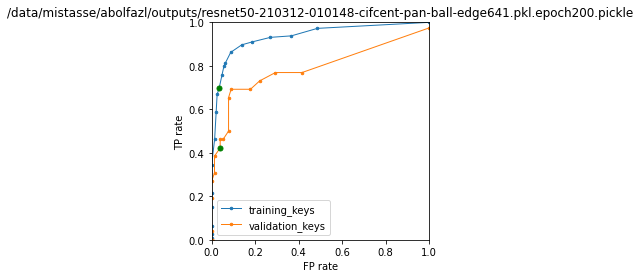

In [18]:
%matplotlib inline
file = filename+".pickle"
# for file in glob.glob("outputs/*210312-*.pickle"):
#for file in glob.glob("outputs/*.pickle"):
if True:
    print(file)
    d = pickle.load(open(file, "rb"))
    fig = None
    for name in ["training_keys", "validation_keys"]:
        fig = plot(d[name], name, fig)
        fig.gca().set_title(file)
    fig.show()

In [ ]:
import pickle
pickle.dump(sets_results, open(filename+".pickle", "wb"))
